## Lab One: Visualization and Data Preprocessing

## 1. Setup and Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re

%matplotlib inline

In [2]:
df = pd.read_csv('data/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [3]:
df.shape

(101766, 50)

## 2. Business Understanding

##### ***Describe the purpose of the data set you selected (i.e. why was this data collected in the first place?).***

The dataset comprises 101,766 hospital records of inpatients diagnosed with diabetes who had hospital stays of 1-14 days, collected from 130 U.S. hospitals between 1999 and 2008. While evidence highlights the benefits of preventative and therapeutic interventions in improving outcomes for diabetic patients, diabetes care during hospital stays often appears inconsistent. This dataset was collected to study early readmission rates within 30 days of discharge, aiming to enhance patient outcomes, reduce morbidity and mortality, and lower hospital management costs.

**Source:** Strack, B., et al. (2014). *UCI Machine Learning Repository: Diabetes 130-US hospitals for years 1999–2008 Data Set.* Retrieved from [https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)

##### ***Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset?***

The main goal of this dataset is to accurately classify hospital readmissions into three categories: within 30 days, after 30 days, or no readmission. This is important because high readmission rates lead to higher healthcare costs, worse patient outcomes, and added pressure on hospital resources. Identifing variables associated with readmission risk provide valuable information to providers for providing targeted treatments. Identifying these variables to achieve good model performace will indicate that we have extracted useful insights from these data. 

##### ***How would you measure the effectiveness of a good prediction algorithm?***

A good prediction algorithm for this objective should prioritize Sensitivity, ensuring it correctly identifies patients at risk of early readmission. This is critical for enabling early interventions and preventative treatments. Once a predefined Sensitivity threshold is achieved (e.g. ~80%), the algorithm's Positive Predictive Value (PPV) should then be optimized to minimize false positives, ensuring resources are efficiently allocated and unnecessary treatments are avoided

We will also split the data into training and validation sets, using cross-validation to evaluate the algorithm's performance on unseen data.

## 3. Data Understanding

##### ***Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.***

### 3.1 Data Attributes

1. **ID Variables**
   - **encounter_id**: Unique identifier of an encounter.
   - **patient_nbr**: Unique identifier of a patient.  
2. **Demographic Variables**
   - **race**: Patient's race (Categorical Levels: Caucasian, Asian, African American, Hispanic, other).
   - **gender**: Patient's gender (Categorical Levels: male, female, unknown/invalid).
   - **age**: Age grouped in 10-year intervals (Categorical Levels: [0-10), [10-20), ..., [90-100)).
   - **weight**: Patient's weight in pounds (Categorical).  
3. **Admission and Discharge Details**
   - **admission_type_id**: Type of admission (Categorical: 9 integer levels representing e.g., Emergency, Urgent, Elective).
   - **discharge_disposition_id**: Type of discharge (Categorical: 29 integer levels representing e.g., Discharged to home, Expired).
   - **admission_source_id**: Source of admission (Categorical: 21 integer levels representing e.g., Physician Referral, Emergency Room).  
4. **Encounter Information**
   - **time_in_hospital**: Number of days in the hospital (Continuous).
   - **payer_code**: Payer for medical services (Categorical: 18 unique levels, e.g., Blue Cross, Medicare).
   - **medical_specialty**: Specialty of admitting physician (Categorical: 73 unique levels, e.g., Cardiology, Internal Medicine).  
5. **Medical History and Diagnostics**
   - **num_lab_procedures**: Number of lab tests performed (Continuous).
   - **num_procedures**: Number of procedures performed (excluding lab tests) (Continuous).
   - **num_medications**: Number of distinct medications administered (Continuous).
   - **number_outpatient**: Number of outpatient visits in the prior year (Continuous).
   - **number_emergency**: Number of emergency visits in the prior year (Continuous).
   - **number_inpatient**: Number of inpatient visits in the prior year (Continuous).
   - **diag_1**, **diag_2**, **diag_3**: Primary and secondary diagnoses (ICD-9 codes) (Categorical: integer values representing 848, 923, and 954 levels, respectively).
   - **number_diagnoses**: Total number of diagnoses recorded (Continuous).  
6. **Lab Results**
   - **max_glu_serum**: Glucose serum test results (Categorical Levels: >200, >300, normal, none).
   - **A1Cresult**: Hemoglobin A1c test results (Categorical Levels: >8, >7, normal, none).  
7. **Medications**
   - Variables for medications: Indicate whether prescribed and dosage changes (Categorical Levels: up, down, steady, no).
   - Drug Classes:
     - **Biguanides** reduce glucose production in the liver and improve insulin sensitivity.  
       - **metformin**: a first-line treatment for type 2 diabetes
     - **Meglitinides** stimulate insulin secretion but act faster and have a shorter duration compared to sulfonylureas. 
       - **repaglinide**
       - **nateglinide**
     - **Sulfonylureas 1st Generation** stimulate the pancreas to produce more insulin. These are older drugs with lower potency and a higher risk of side effects, such as hypoglycemia.  
       - **chlorpropamide**
       - **acetohexamide**
       - **tolbutamide**
       - **tolazamide**
     - **Sulfonylureas 2nd Generation** stimulate the pancreas to produce more insulin. These are newer, more potent drugs with shorter half-lives, reducing the risk of hypoglycemia.  
       - **glimepiride**
       - **glipizide**
       - **glyburide**
     - **Thiazolidinediones (TZDs)** improve insulin sensitivity in muscle and fat tissue. They can have serious side effects, including weight gain and fluid retention. (They have been withdrawn in many markets due to evidence of liver toxicity.)
       - **pioglitazone**
       - **rosiglitazone**
       - **troglitazone**
     - **Alpha-Glucosidase Inhibitors** delay carbohydrate digestion and absorption in the intestines, reducing post-meal blood sugar spikes.
       - **acarbose**
       - **miglitol**
     - **DPP-4 Inhibitors** enhance incretin hormone levels to increase insulin release and decrease glucagon.
       - **citoglipton**: An unknown drug and potential error in the dataset; it may be a misspelling of *sitagliptin*.
     - **Insulin and Combinations**: Combination drugs combine two medications to simplify treatment and target multiple mechanisms for blood sugar control.
       - **insulin** directly supplements or replaces natural insulin in the body, essential for type 1 and advanced type 2 diabetes management.
       - **glyburide-metformin**
       - **glipizide-metformin**
       - **glimepiride-pioglitazone**
       - **metformin-rosiglitazone**
       - **metformin-pioglitazone**
     - **Non-Diabetes Medications**
       - **examide** is a diuretic primarily prescribed for cardiovascular or renal issues, not blood sugar control.  
8. **Medication Outcome Variables**
   - **change**: Indicates if diabetic medications were changed during the encounter (Categorical Levels: change, no change).
   - **diabetesMed**: Indicates if diabetic medications were prescribed (Categorical Levels: yes, no).
9. **Target Variable**
   - **readmitted**: Readmission status (Target Classes: <30, >30, No).  

---

##### Metadata Categories

1. **admission_type_id**
   - 1: Emergency; 2: Urgent; 3: Elective; 4: Newborn; 5: Not Available; 6: NULL; 7: Trauma Center; 8: Not Mapped    
2. **discharge_disposition_id**
   - 1: Discharged to home; 2: Discharged/transferred to another short-term hospital; 3: Discharged/transferred to SNF; 4: Discharged/transferred to ICF; 5: Discharged/transferred to another type of inpatient care institution; 6: Discharged/transferred to home with home health service; 7: Left AMA; 8: Discharged/transferred to home under care of Home IV provider; 9: Admitted as an inpatient to this hospital; 10: Neonate discharged to another hospital for neonatal aftercare; 11: Expired; 12: Still patient or expected to return for outpatient services; 13: Hospice / home; 14: Hospice / medical facility; 15: Discharged/transferred within this institution to Medicare approved swing bed; 16: Discharged/transferred/referred to another institution for outpatient services; 17: Discharged/transferred/referred to this institution for outpatient services; 18: NULL; 19: Expired at home (Medicaid only, hospice); 20: Expired in a medical facility (Medicaid only, hospice); 21: Expired, place unknown (Medicaid only, hospice); 22: Discharged/transferred to another rehab facility including rehab units of a hospital; 23: Discharged/transferred to a long-term care hospital; 24: Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare; 25: Not Mapped; 26: Unknown/Invalid; 27: Discharged/transferred to a federal health care facility; 28: Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital; 29: Discharged/transferred to a Critical Access Hospital (CAH); 30: Discharged/transferred to another type of health care institution not defined elsewhere 
3. **admission_source_id**
   - 1: Physician Referral; 2: Clinic Referral; 3: HMO Referral; 4: Transfer from a hospital; 5: Transfer from a Skilled Nursing Facility (SNF); 6: Transfer from another health care facility; 7: Emergency Room; 8: Court/Law Enforcement; 9: Not Available; 10: Transfer from critical access hospital; 11: Normal Delivery; 12: Premature Delivery; 13: Sick Baby; 14: Extramural Birth; 15: Not Available; 17: NULL; 18: Transfer from Another Home Health Agency; 19: Readmission to Same Home Health Agency; 20: Not Mapped; 21: Unknown/Invalid; 22: Transfer from hospital inpatient/same facility resulting in a separate claim; 23: Born inside this hospital; 24: Born outside this hospital; 25: Transfer from Ambulatory Surgery Center; 26: Transfer from Hospice  

In [4]:
# # Display the variable metadata in a more readable table format
# metadata = pd.read_csv('data/diabetes+130-us+hospitals+for+years+1999-2008/IDS_mapping.csv')
# print(metadata.to_markdown(index=False))

### 3.2 Data Cleaning

##### ***Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems?***

#### 3.2.1 Missing Values

##### **A. Missing Data Summary Statistics and Visualization**

This identifies columns with NaNs.

In [5]:
# Find the NaNs
nan_sums = df.isna().sum()
nan_sums_nonzero = nan_sums[nan_sums != 0]
nan_sums_nonzero

# Calculate percentages
nan_percentages = (nan_sums_nonzero / len(df)) * 100

# Create a DataFrame of NaN counts and percentages
nan_summary = pd.DataFrame({
    'NaN Count': nan_sums_nonzero,
    'NaN Percentage': nan_percentages
}).sort_values(by='NaN Count', ascending=False)
nan_sums_nonzero

nan_summary

NaN Count  NaN Percentage
max_glu_serum      96420       94.746772
A1Cresult          84748       83.277322

This identifies columns with '?' values.

In [6]:
# Find `?` values and decide how to deal with them
questionmark_sums = (df == '?').sum()
questionmark_sums_nonzero = questionmark_sums[questionmark_sums != 0]
questionmark_sums_nonzero

# Calculate percentages
questionmark_percentages = (questionmark_sums_nonzero / len(df)) * 100

# Create a DataFrame of NaN counts and percentages
questionmark_summary = pd.DataFrame({
    '? Count': questionmark_sums_nonzero,
    '? Percentage': questionmark_percentages
}).sort_values(by='? Count', ascending=False)
questionmark_sums_nonzero

questionmark_summary

? Count  ? Percentage
weight               98569     96.858479
medical_specialty    49949     49.082208
payer_code           40256     39.557416
race                  2273      2.233555
diag_3                1423      1.398306
diag_2                 358      0.351787
diag_1                  21      0.020636

In [7]:
# Replace `?` with NaN for now
df_clean = df.copy()
df_clean = df.replace('?', np.nan)

In [8]:
# How many missing values are in each weight class?

# Define the order for weight classes
weight_order = [
    "[0-25)", "[25-50)", "[50-75)", "[75-100)", "[100-125)", 
    "[125-150)", "[150-175)", "[175-200)", ">200", np.nan
]

weight_counts = df_clean['weight'].value_counts(dropna=False)

# Reindex the counts based on the custom order
sorted_weight_counts = weight_counts.reindex(weight_order)
sorted_weight_counts

weight
[0-25)          48
[25-50)         97
[50-75)        897
[75-100)      1336
[100-125)      625
[125-150)      145
[150-175)       35
[175-200)       11
>200             3
NaN          98569
Name: count, dtype: int64

In [9]:
# Let's look at age. The low weights will likely be young patients.

df_clean['age'].value_counts(dropna=False)

age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

In [10]:
under_50_lbs = ((df_clean['weight'] == '[0-25)') | (df_clean['weight'] == '[25-50)')).sum()
under_10_yrs = (df_clean['age'] == '[0-10)').sum()

print(f'There are {under_50_lbs} patients under 50 lbs and {under_10_yrs} patients under 10 years old.')

There are 145 patients under 50 lbs and 161 patients under 10 years old.


In [11]:
# Let's look closer at max_glu_serum representing glucose serum test results
# One of the categorical levels is `none`. This test is not conducted on most patients.

df_clean['max_glu_serum'].value_counts(dropna=False)

max_glu_serum
NaN     96420
Norm     2597
>200     1485
>300     1264
Name: count, dtype: int64

In [12]:
# Let's look at A1Cresult
# One of the categorical levels is `none`. This test is not conducted on most patients.

df_clean['A1Cresult'].value_counts(dropna=False)

A1Cresult
NaN     84748
>8       8216
Norm     4990
>7       3812
Name: count, dtype: int64

In [13]:
print(f'There are {df_clean['medical_specialty'].nunique()} unique categories in the `medical_specialty` variable.')
med_specialty_categories = df_clean['medical_specialty'].unique()
med_specialty_categories

There are 72 unique categories in the `medical_specialty` variable.


array(['Pediatrics-Endocrinology', nan, 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

In [14]:
value_counts = df_clean['medical_specialty'].value_counts(dropna=False)[df_clean['medical_specialty'].value_counts(dropna=False)>1000]
percentages = (value_counts / len(df_clean['medical_specialty'])) * 100
med_specialty_df = pd.DataFrame({
    'Category': value_counts.index,
    'Count': value_counts.values,
    'Percentage (%)': percentages.values,
})
med_specialty_df

Category  Count  Percentage (%)
0                         NaN  49949       49.082208
1            InternalMedicine  14635       14.381031
2            Emergency/Trauma   7565        7.433720
3      Family/GeneralPractice   7440        7.310890
4                  Cardiology   5352        5.259124
5             Surgery-General   3099        3.045221
6                  Nephrology   1613        1.585009
7                 Orthopedics   1400        1.375705
8  Orthopedics-Reconstructive   1233        1.211603
9                 Radiologist   1140        1.120217

In [15]:
value_counts = df_clean['payer_code'].value_counts(dropna=False)
percentages = (value_counts / len(df_clean['payer_code'])) * 100
payer_df = pd.DataFrame({
    'Category': value_counts.index,
    'Count': value_counts.values,
    'Percentage (%)': percentages.values,
})
payer_df

Category  Count  Percentage (%)
0       NaN  40256       39.557416
1        MC  32439       31.876069
2        HM   6274        6.165124
3        SP   5007        4.920111
4        BC   4655        4.574219
5        MD   3532        3.470707
6        CP   2533        2.489043
7        UN   2448        2.405519
8        CM   1937        1.903386
9        OG   1033        1.015074
10       PO    592        0.581727
11       DM    549        0.539473
12       CH    146        0.143466
13       WC    135        0.132657
14       OT     95        0.093351
15       MP     79        0.077629
16       SI     55        0.054046
17       FR      1        0.000983

In [16]:
value_counts = df_clean['race'].value_counts(dropna=False)
percentages = (value_counts / len(df_clean['race'])) * 100
race_df = pd.DataFrame({
    'Category': value_counts.index,
    'Count': value_counts.values,
    'Percentage (%)': percentages.values,
})
race_df

Category  Count  Percentage (%)
0        Caucasian  76099       74.778413
1  AfricanAmerican  19210       18.876639
2              NaN   2273        2.233555
3         Hispanic   2037        2.001651
4            Other   1506        1.479866
5            Asian    641        0.629876

It seems reasonable that not every patient would have 3 diagnoses. Only 21 are missing diag_1. Are those also missing diag_2 and diag_3?

In [17]:
# Get the indexes where 'diag_1' was '?' (now NaN)
indexes_with_diag_1_questionable = df_clean[df_clean['diag_1'].isna()].index.tolist()

# Look at the rows where diag_1 is '?'
rows_with_diag_1_questionable = df_clean.loc[indexes_with_diag_1_questionable, ['diag_1', 'diag_2', 'diag_3']]

rows_with_diag_1_questionable

diag_1  diag_2  diag_3
518      NaN     780     997
1006     NaN     595   250.6
1267     NaN  250.82     401
1488     NaN     276     594
3197     NaN  250.01     428
7845     NaN     496     788
14503    NaN     276  250.01
19714    NaN     112     585
32514    NaN     998     427
37693    NaN     780     295
49516    NaN     707     427
56931    NaN     585     427
57058    NaN     V63     414
57737    NaN     276     V08
60314    NaN     427     486
61369    NaN     780     780
61763    NaN     426     427
66848    NaN     780     427
86018    NaN  250.02     438
87181    NaN     NaN     NaN
98396    NaN     780     250

In [18]:
value_counts = df_clean['diag_3'].value_counts(dropna=False)[df_clean['diag_3'].value_counts(dropna=False)>1400]
percentages = (value_counts / len(df_clean['diag_3'])) * 100
diag3_df = pd.DataFrame({
    'Category': value_counts.index,
    'Count': value_counts.values,
    'Percentage (%)': percentages.values,
})
diag3_df

Category  Count  Percentage (%)
0       250  11555       11.354480
1       401   8289        8.145157
2       276   5175        5.085195
3       428   4577        4.497573
4       427   3955        3.886367
5       414   3664        3.600417
6       496   2605        2.559794
7       403   2357        2.316098
8       585   1992        1.957432
9       272   1969        1.934831
10      599   1941        1.907317
11      NaN   1423        1.398306

In [19]:
admin_variables = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
null_values = [6, 18, 17]

admin_null_df = pd.DataFrame({
    'Variable': pd.Series(dtype='str'),
    'Null_Value': pd.Series(dtype='int'),
    'Count': pd.Series(dtype='int'),
    'Percentage (%)': pd.Series(dtype='float')
})

for var, null_val in zip(admin_variables, null_values):
    # Get value counts for the current variable
    value_counts = df_clean[var].value_counts(dropna=False)
    
    # Extract the count and calculate percentage for the specific "null" value
    count = value_counts.get(null_val, 0)  # Use .get() to safely retrieve the count
    percentage = (count / len(df_clean[var])) * 100

    # Create a temporary DataFrame for this variable
    temp_df = pd.DataFrame({
        'Variable': [var],
        'Null_Value': [null_val],
        'Count': [count],
        'Percentage (%)': [percentage]
    })

    # Concatenate the temporary DataFrame with the main one
    admin_null_df = pd.concat([admin_null_df, temp_df], ignore_index=True)

admin_null_df

Variable  Null_Value  Count  Percentage (%)
0         admission_type_id           6   5291        5.199182
1  discharge_disposition_id          18   3691        3.626948
2       admission_source_id          17   6781        6.663326

Variables with missing values (either `NaN` or `?`) include `weight`, `max_glu_serum`, `A1Cresult`, `medical_specialty`, `payer_code`, `race`, `diag_3`, `diag_2`, and `diag_1`. There are also integer levels representing `NULL` in `admission_type_id`, `discharge_disposition_id`, and `admission_source_id`.

##### Strategies for dealing with missing data:

- It seems that for features with a high percentage of missing values (e.g. weight, max_glu_serum, A1Cresult), we should remove these features from our analysis.   
- However, is there a way to examine the rows with these values to determine their predictive power? It may be that prediction can be improved significantly with these. Part of the conclusion and recommendation may be for hospitals to include these test for all diabetes patients.
  - Check correlations between these variables and the target variable for rows where data is available.
  - Use a random forest model to evaluate feature importance to see if these features contribute significantly to prediction when included.
  - Investigate differences in the target variable for patients with and without these values.
  - Consider that these may test for long term markers rather than parameters critical for acute care. Also, they may be done at routine doctors appointments and they are avoided during acute treatment to avoid duplication.    
- It would be interesting to investigate if a certain payer code or medical specialty for which we have records are associated with lower rates of treatment or higher rates of re-admission.
  - Use bar plots or heat maps to look into how payer codes and medical specialties are distributed across patients with different outcomes (e.g. re-admission rates).
  - Certain payer codes or specialties may correlate with lower rates of tests or treatments, which could indicate disparities in care.
  - Consider if it is better to recode a '?', the value in the original dataset, with NaN or a different category like 'Unknown'.  
- Features with < 3% missing values (e.g. race, diag_3, diag_2, diag_1) imputation seems like a viable option, either using the mode or something more sophisticated like a multi-class classification technique.
  - It is also plausible that some patients only have one or two diagnoses so that is why diag_2 and diag_3 are missing.
- There are also levels coded as integers representing `NULL` in admission_type_id (6), discharge_disposition_id (18), and admission_source_id (17). It is unclear what this means. 

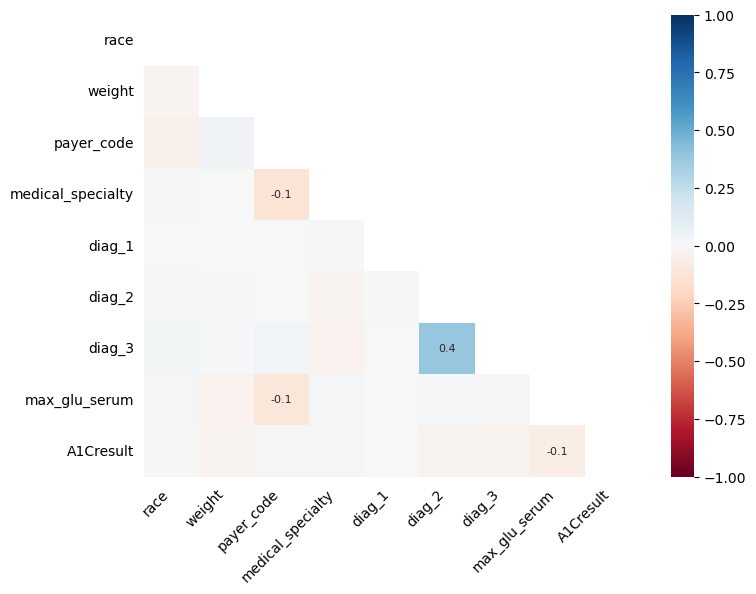

In [20]:
import missingno as msno

# Visualize missing data as a heatmap
msno.heatmap(df_clean, fontsize=10, figsize=(8, 6))
# plt.savefig(f'plots/missing_heatmap.png')
plt.show()

The heatmap displays correlations in the patterns of missingness between variables. A positive correlation of 0.4 between diag_2 and diag_3 indicates that if a record is missing a value for diag_2, there is an increased likelihood that it is also missing a value for diag_3. This relationship suggests that if diag_2 is missing, we may be able to use diag_3 (if available) to inform our imputation strategy.  
The lack of strong correlations between most other variables suggests their missingness is likely independent of one another. However, negative correlations (e.g., -0.1 between medical_specialty and max_glu_serum) indicate a weak inverse relationship, meaning that when one column has a missing value, the other is slightly less likely to be missing.

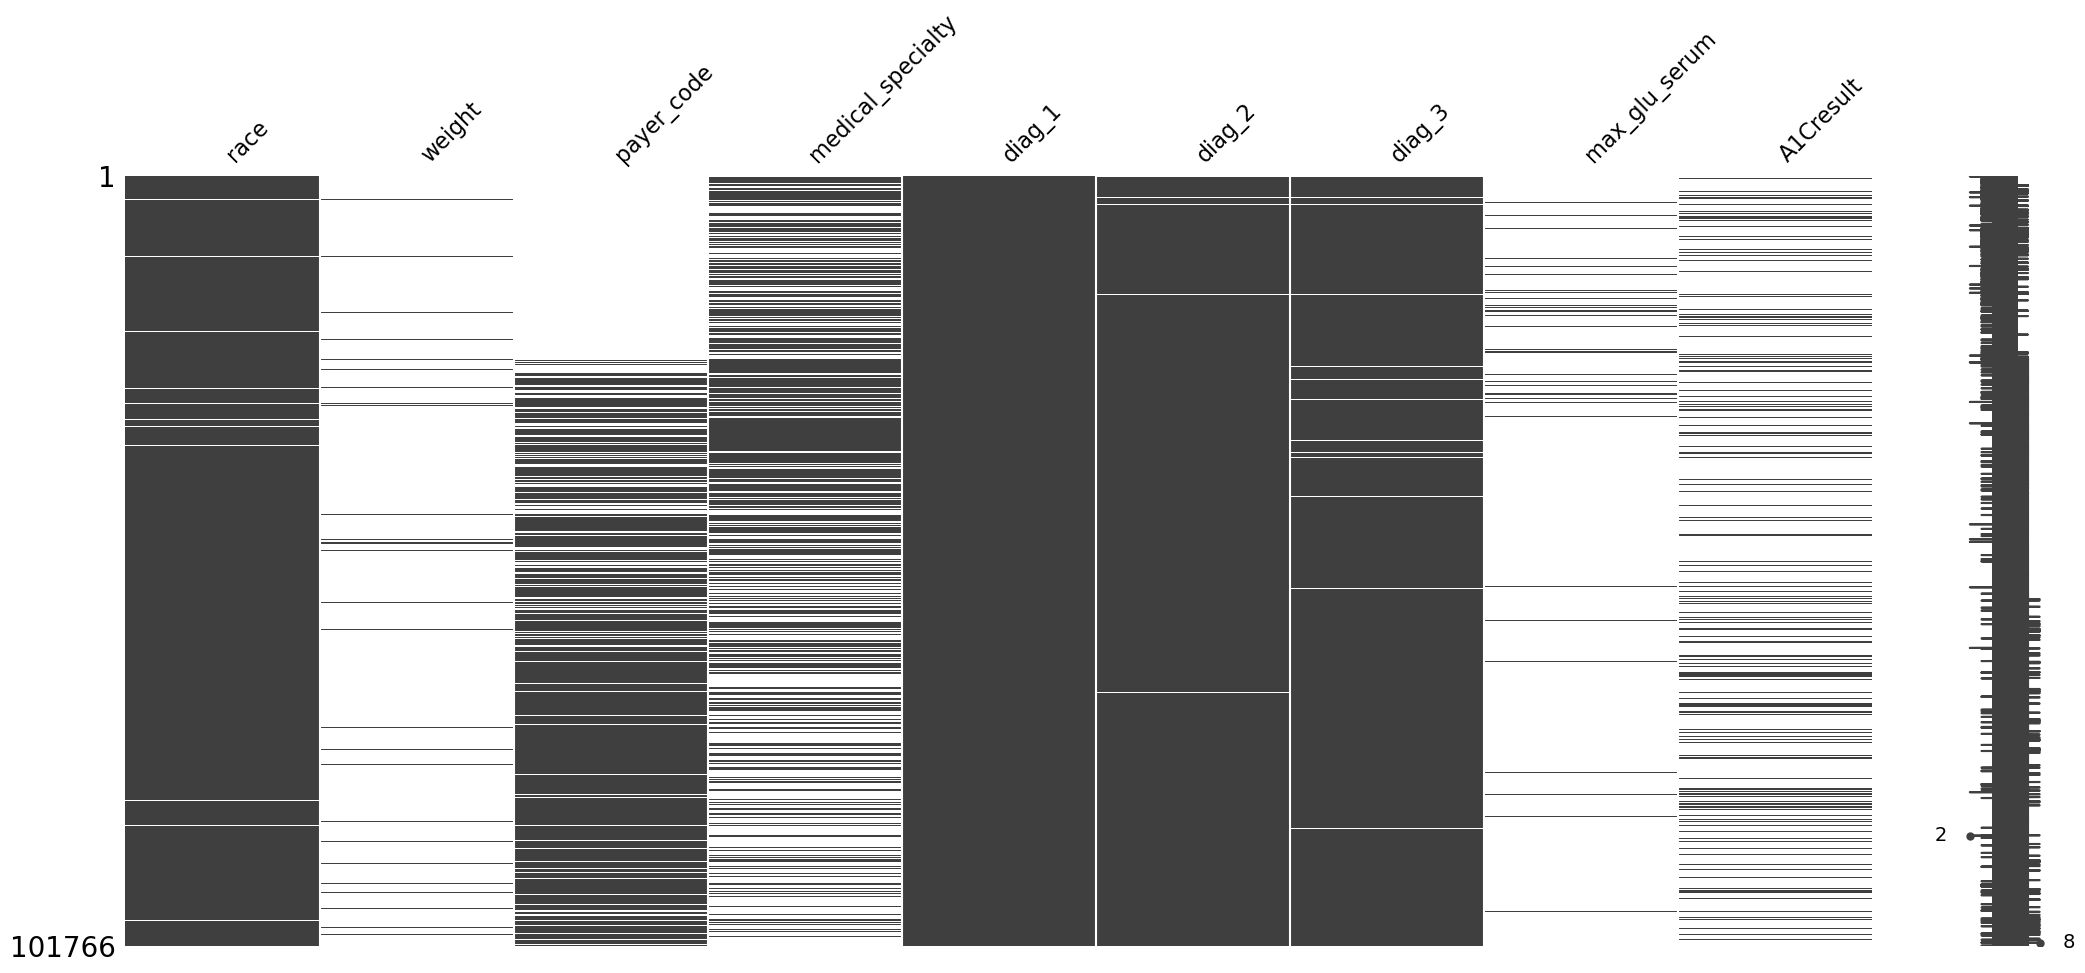

In [21]:
# Visualize missing data as a matrix
msno.matrix(df_clean.loc[:, df_clean.isnull().any()])
# plt.savefig(f'plots/missing_matrix.png')
plt.show()

This bar graph displays records across the full dataset, with missing values shown in white. There doesn’t appear to be a strong indication that specific rows are disproportionately affected by missingness. Patterns of missing values seem fairly distributed across rows without obvious clustering. This suggests that while variable-level missingness is significant, row-level missingness may not require targeted removal or specific handling.The dendrogram provides insights into relationships between variables based on their missingness patterns. Diagnosis codes (diag_1, diag_2, diag_3) cluster together, indicating shared trends in missing values, which may reflect relationships in the data collection process. Variables like max_glu_serum and weight also cluster, though this may be less meaningful due to the high proportion of missing data in these columns.

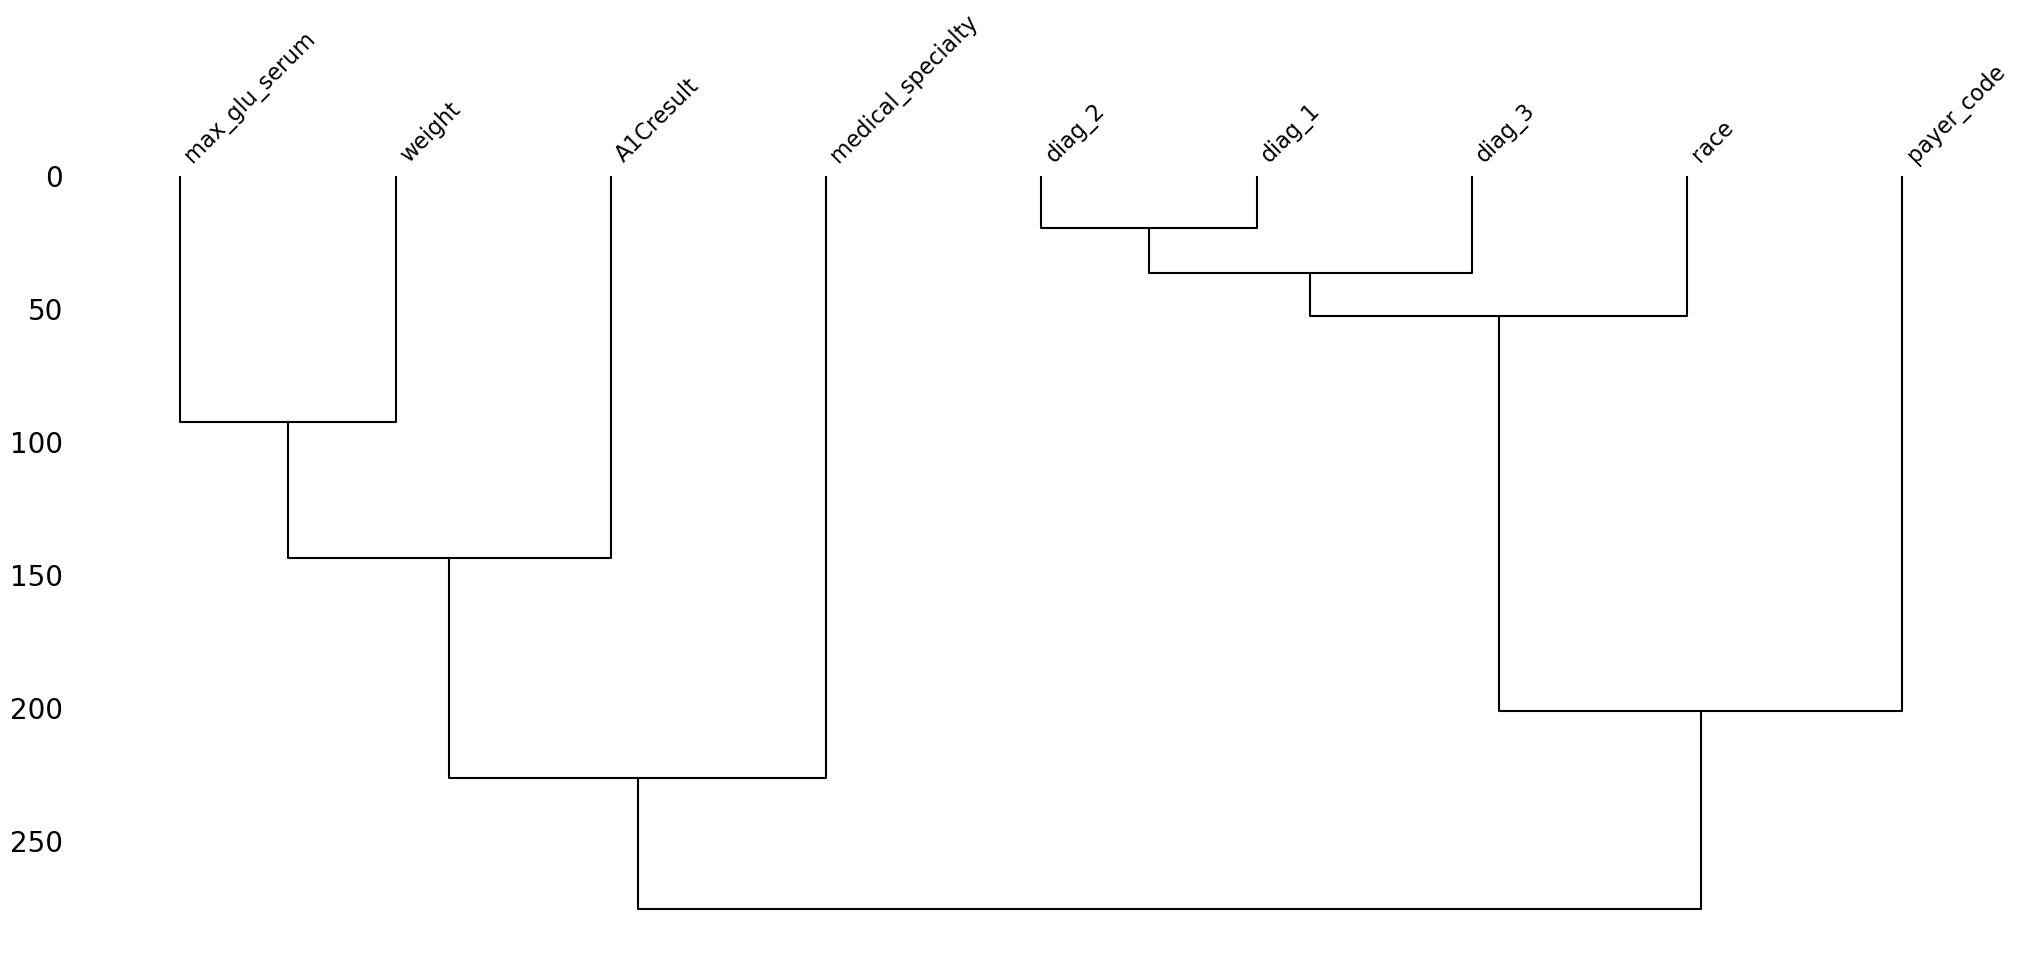

In [22]:
# Visualize dendrogram for missingness correlations
msno.dendrogram(df_clean.loc[:, df_clean.isnull().any()])
# plt.savefig(f'plots/missing_dendrogram.png')
plt.show()

The dendrogram provides insights into relationships between variables based on their missingness patterns. Diagnosis codes (diag_1, diag_2, diag_3) cluster together, indicating shared trends in missing values, which may reflect relationships in the data collection process. Variables like max_glu_serum and weight also cluster, though this may be less meaningful due to the high proportion of missing data in these columns.

##### **B. Decisions on handling the missing data for further processing**

There isn't an Unknown category in medical_specialty, payer_code, or race. It seems reasonable to make the NaN ('?') values an Unknown category rather than a NaN. Also, it seems plausible that not every patient would have more than one diagnosis code. Converting NaN ('?') to Unknown/None seems reasonable for the diagnosis codes. The data set documentation describes a 'none' category for both max_glu_serum and A1Cresult. Making the assumption that the NaN values are the values in the 'none' category and 'none' likely represents patients that did not receive this test, NaN values were replaced with Untested.

In [23]:
# Replace NaN ('?') with 'Unknown' in the specified columns
columns_to_update_1 = ['medical_specialty', 'payer_code', 'race']
df_clean[columns_to_update_1] = df_clean[columns_to_update_1].replace(np.nan, 'Unknown')

# Replace NaN ('?') with 'Unknown' in the specified columns
columns_to_update_2 = ['diag_1', 'diag_2', 'diag_3']
df_clean[columns_to_update_2] = df_clean[columns_to_update_2].replace(np.nan, 'Unknown/None')

# Replace NaN with 'Untested' in the specified columns
columns_to_update_3 = ['max_glu_serum', 'A1Cresult']
df_clean[columns_to_update_3] = df_clean[columns_to_update_3].replace(np.nan, 'Untested')

#### 3.2.2 Duplicates

In [24]:
duplicate_count = df_clean.duplicated().sum()
print(f'The dataset has {duplicate_count} duplicate records.')

The dataset has 0 duplicate records.


#### 3.2.3 Remove ID variable: 'encounter_id'

In [25]:
# Verify that encounter_id is unique for each record.
df_clean['encounter_id'].nunique() == len(df_clean)

True

In [26]:
if 'encounter_id' in df_clean:
    del df_clean['encounter_id']

# if 'patient_nbr' in df_clean:
#     del df_clean['patient_nbr']

print( df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  numb

In [27]:
# Convert categorical variables `patient_nbr`, `admission_type_id`, `discharge_disposition_id`, `admission_source_id`
# from integer to object datatype.
categoricalInt_cols = ['patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[categoricalInt_cols] = df_clean[categoricalInt_cols].astype('category')
df_clean[['patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']].dtypes

patient_nbr                 category
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
dtype: object

### 3.3 Statistical summaries of the features

##### ***Give simple, appropriate statistics (range, mode, mean, median, variance, counts, etc.) for the most important attributes and describe what they mean or if you found something interesting. Note: You can also use data from other sources for comparison. Explain the significance of the statistics run and why they are meaningful.***

#### 3.3.1 Numerical features

In [28]:
# Summary statistics of the numerical features

# Calculate basic statistics
desc = df_clean.describe()  # Includes count, mean, std, 5-number summary
modes_num = df_clean.mode(numeric_only=True).iloc[0]  # Get the first mode for each column
variances = df_clean.var(numeric_only=True)
ranges = df_clean.max(numeric_only=True) - df_clean.min(numeric_only=True)

# Create a summary DataFrame
num_stats_df = pd.DataFrame({
    'Count': desc.loc['count'],
    'Mean': desc.loc['mean'],
    'Std': desc.loc['std'],
    'Min': desc.loc['min'],
    '25%': desc.loc['25%'],
    'Median': desc.loc['50%'],
    '75%': desc.loc['75%'],
    'Max': desc.loc['max'],
    'Range': ranges,
    'Variance': variances,
    'Mode': modes_num
})

# Rearrange and clean up for better presentation
num_stats_df = num_stats_df[['Count', 'Mean', 'Std', 'Variance', 'Min', '25%', 'Median', '75%', 'Max', 'Range', 'Mode']]
num_stats_df.reset_index(inplace=True)  # Optional: Keep variable names as a column
num_stats_df.rename(columns={'index': 'Variable'}, inplace=True)

# Display the final DataFrame
num_stats_df

Variable     Count       Mean        Std    Variance  Min   25%  \
0    time_in_hospital  101766.0   4.395987   2.985108    8.910868  1.0   2.0   
1  num_lab_procedures  101766.0  43.095641  19.674362  387.080530  1.0  31.0   
2      num_procedures  101766.0   1.339730   1.705807    2.909777  0.0   0.0   
3     num_medications  101766.0  16.021844   8.127566   66.057332  1.0  10.0   
4   number_outpatient  101766.0   0.369357   1.267265    1.605961  0.0   0.0   
5    number_emergency  101766.0   0.197836   0.930472    0.865779  0.0   0.0   
6    number_inpatient  101766.0   0.635566   1.262863    1.594824  0.0   0.0   
7    number_diagnoses  101766.0   7.422607   1.933600    3.738810  1.0   6.0   

   Median   75%    Max  Range  Mode  
0     4.0   6.0   14.0     13     3  
1    44.0  57.0  132.0    131     1  
2     1.0   2.0    6.0      6     0  
3    15.0  20.0   81.0     80    13  
4     0.0   0.0   42.0     42     0  
5     0.0   0.0   76.0     76     0  
6     0.0   1.0   21.0     21     0  
7     8.0   9.0   16.0     15     9

We computed the following summary statistics for the numerical variables: count, mean, standard deviation, variance, five-number summary (minimum and maximum, 25th and 75th percentile, and median), range, and mode. These tell us how many records there are and give us a sense of the distribution of the data. We have the measures of center (mean, median and mode), as well as measures of spread (standard deviation and variance). We also can see the full range of the data and and where the middle 50% of the data lie.  
For many of these features the mean and median (and also mostly the mode) are similar values. The distribution appear to be right skewed in many cases by high outliers. The exception to that seems to be number of lab procedures, which seems to be more normally distributed.  

In [29]:
# Summary statistics of the categorical features

# Calculate basic statistics
desc_cat = df_clean.describe(include=['object', 'category'])  # Includes count, unique, top, freq
top_percentage = (desc_cat.loc['freq'] / desc_cat.loc['count'] * 100).round(2)

# Create a summary DataFrame
cat_stats_df = pd.DataFrame({
    'Count': desc_cat.loc['count'],
    'Unique': desc_cat.loc['unique'],
    'Top': desc_cat.loc['top'],
    'Freq': desc_cat.loc['freq'],
    'Top %': top_percentage
})

# Rearrange and clean up for better presentation
cat_stats_df.reset_index(inplace=True)  # Optional: Keep variable names as a column
cat_stats_df.rename(columns={'index': 'Variable'}, inplace=True)

# Display the final DataFrame
cat_stats_df

Variable   Count Unique        Top    Freq      Top %
0                patient_nbr  101766  71518   88785891      40   0.039306
1                       race  101766      6  Caucasian   76099  74.778413
2                     gender  101766      3     Female   54708  53.758623
3                        age  101766     10    [70-80)   26068  25.615628
4                     weight    3197      9   [75-100)    1336  41.789177
5          admission_type_id  101766      8          1   53990  53.053083
6   discharge_disposition_id  101766     26          1   60234  59.188727
7        admission_source_id  101766     17          7   57494  56.496276
8                 payer_code  101766     18    Unknown   40256  39.557416
9          medical_specialty  101766     73    Unknown   49949  49.082208
10                    diag_1  101766    717        428    6862    6.74292
11                    diag_2  101766    749        276    6752   6.634829
12                    diag_3  101766    790        250   11555   11.35448
13             max_glu_serum  101766      4   Untested   96420  94.746772
14                 A1Cresult  101766      4   Untested   84748  83.277322
15                 metformin  101766      4         No   81778  80.358862
16               repaglinide  101766      4         No  100227  98.487707
17               nateglinide  101766      4         No  101063    99.3092
18            chlorpropamide  101766      4         No  101680  99.915492
19               glimepiride  101766      4         No   96575  94.899082
20             acetohexamide  101766      2         No  101765  99.999017
21                 glipizide  101766      4         No   89080  87.534147
22                 glyburide  101766      4         No   91116  89.534815
23               tolbutamide  101766      2         No  101743  99.977399
24              pioglitazone  101766      4         No   94438  92.799167
25             rosiglitazone  101766      4         No   95401  93.745455
26                  acarbose  101766      4         No  101458  99.697345
27                  miglitol  101766      4         No  101728  99.962659
28              troglitazone  101766      2         No  101763  99.997052
29                tolazamide  101766      3         No  101727  99.961677
30                   examide  101766      1         No  101766      100.0
31               citoglipton  101766      1         No  101766      100.0
32                   insulin  101766      4         No   47383  46.560737
33       glyburide-metformin  101766      4         No  101060  99.306252
34       glipizide-metformin  101766      2         No  101753  99.987226
35  glimepiride-pioglitazone  101766      2         No  101765  99.999017
36   metformin-rosiglitazone  101766      2         No  101764  99.998035
37    metformin-pioglitazone  101766      2         No  101765  99.999017
38                    change  101766      2         No   54755  53.804807
39               diabetesMed  101766      2        Yes   78363  77.003125
40                readmitted  101766      3         NO   54864  53.911916

For the categorical variables (including the target), we computed the following summary statistics: count, number of unique values (levels), `Top` - the level that occurs most frequently, `Freq` - the number of occurences of the top level, and the percentage of the values within that level.  
This indicates that for many features, nearly all of the values fall within one category (e.g. over 99% of patients do not take 15 out of the 23 drugs in the dataset). We also can see that there are repeated patients in the dataset.  

#### 3.3.2 Categorical features and target variable

In [30]:
# Find the proportion of each response class.
print(df_clean['readmitted'].value_counts()/df_clean['readmitted'].count())

readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: count, dtype: float64


The response class is unbalanced with 54% patient records not being readmitted, 35% being readmitted in greater than 30 days, and 11% being readmitted in less than 30 days.

In [31]:
# Find how many patients are have more than one encounter.

patient_counts = df_clean['patient_nbr'].value_counts(dropna=False)
repeated_patients = patient_counts[patient_counts > 1]
num_repeated_patients = len(repeated_patients)
print(f"Number of patients with more than one record: {num_repeated_patients}")

repeated_patients.min(), repeated_patients.max()

Number of patients with more than one record: 16773


(2, 40)

patient_nbr is not unique for each record in the dataset indicating that there are repeated measures. 16,773 patients have between 2 and 40 encounters.

In [32]:
# Verify that values in 'examide' and 'citoglipton' are 100% 'No' across the full dataset
print(df_clean['examide'].value_counts())
print(df_clean['citoglipton'].value_counts())

examide
No    101766
Name: count, dtype: int64
citoglipton
No    101766
Name: count, dtype: int64


We should be able to eliminate these variables, since they aren't offering any insight.

#### 3.3.3 Remove zero variance and high missing variables

In [33]:
# Remove examide and citoglipton from the dataset.
df_clean = df_clean.drop(columns=['examide', 'citoglipton'])

df_clean = df_clean.drop(columns=['weight'])

print( df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   patient_nbr               101766 non-null  category
 1   race                      101766 non-null  object  
 2   gender                    101766 non-null  object  
 3   age                       101766 non-null  object  
 4   admission_type_id         101766 non-null  category
 5   discharge_disposition_id  101766 non-null  category
 6   admission_source_id       101766 non-null  category
 7   time_in_hospital          101766 non-null  int64   
 8   payer_code                101766 non-null  object  
 9   medical_specialty         101766 non-null  object  
 10  num_lab_procedures        101766 non-null  int64   
 11  num_procedures            101766 non-null  int64   
 12  num_medications           101766 non-null  int64   
 13  number_outpatient         101

#### 3.3.4 Outliers

In [34]:
# Calculate IQR and outlier bounds
num_stats_df['IQR'] = num_stats_df['75%'] - num_stats_df['25%']  # Interquartile Range
num_stats_df['Lower_IQR_Bound'] = num_stats_df['25%'] - 1.5 * num_stats_df['IQR']
num_stats_df['Upper_IQR_Bound'] = num_stats_df['75%'] + 1.5 * num_stats_df['IQR']

outliers = {} # Empty dictionary to store outliers for each variable
total_rows = len(df_clean)

for var in df_clean.select_dtypes(include='number').columns:
    # Get lower and upper bounds for the variable
    lower_bound = num_stats_df.loc[num_stats_df['Variable'] == var, 'Lower_IQR_Bound'].values[0]
    upper_bound = num_stats_df.loc[num_stats_df['Variable'] == var, 'Upper_IQR_Bound'].values[0]
    
    # Find outliers
    outliers[var] = df_clean[(df_clean[var] < lower_bound) | (df_clean[var] > upper_bound)][var]

# Summarize outliers
outlier_counts = {var: len(outlier_values) for var, outlier_values in outliers.items()}
outlier_proportions = {var: round((count / total_rows) * 100, 2) for var, count in outlier_counts.items()}  # Convert to percentage and round

# Create a summary DataFrame
outliers_summary_df = pd.DataFrame({
    'Variable': outlier_counts.keys(),
    'Outlier Count': outlier_counts.values(),
    'Outlier Proportion (%)': outlier_proportions.values()  # Updated to percentage
})

outliers_summary_df

Variable  Outlier Count  Outlier Proportion (%)
0    time_in_hospital           2252                    2.21
1  num_lab_procedures            143                    0.14
2      num_procedures           4954                    4.87
3     num_medications           2557                    2.51
4   number_outpatient          16739                   16.45
5    number_emergency          11383                   11.19
6    number_inpatient           7049                    6.93
7    number_diagnoses            281                    0.28

Suspected outliers were identified using the interquartile range (IQR) method: values below the 25th percentile minus 1.5 times the IQR or above the 75th percentile plus 1.5 times the IQR were classified as outliers. Variables related to hospital visits (e.g. number_outpatient, number_emergency, number_inpatient) exhibited a higher proportion of outliers, with more than 5% of observations flagged. These variables had low mean, median, and mode values, but a small subset of patients had disproportionately high numbers of visits.  
Other numeric variables had fewer than 5% of observations defined as outliers. It may be worth examining potential correlations among the hospital visit variables, as certain patients could be more prone to frequent hospital visits and associated interventions.

#### 3.3.5 Data preprocessing: Explicitly set the order of ordinal variables

In [35]:
# # Define the correct order for each variable
readmit_order = ['<30', '>30', 'NO']
drug_order = ['No', 'Down', 'Steady', 'Up']
max_glu_serum_order = ['Untested', 'Norm', '>200', '>300']
a1cresult_order = ['Untested', 'Norm', '>7', '>8']
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'] 
# # weight_order = ['[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', 
# #                 '[125-150)', '[150-175)', '[175-200)', '>200'] # dropped this column

# # List of drug-related variables
drug_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol', 
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']

# # Reorder categories in the DataFrame
df_clean['readmitted'] = pd.Categorical(df_clean['readmitted'], categories=readmit_order, ordered=True)
df_clean['max_glu_serum'] = pd.Categorical(df_clean['max_glu_serum'], categories=max_glu_serum_order, ordered=True)
df_clean['A1Cresult'] = pd.Categorical(df_clean['A1Cresult'], categories=a1cresult_order, ordered=True)
df_clean['age'] = pd.Categorical(df_clean['age'], categories=age_order, ordered=True)
# df_clean['weight'] = pd.Categorical(df_clean['weight'], categories=weight_order, ordered=True)

for col in drug_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.Categorical(df_clean[col], categories=drug_order, ordered=True)

### 3.4 Visualization of the attributes

#### 3.4.1 Target variable

This plots the distribution of the target variable, readmitted.

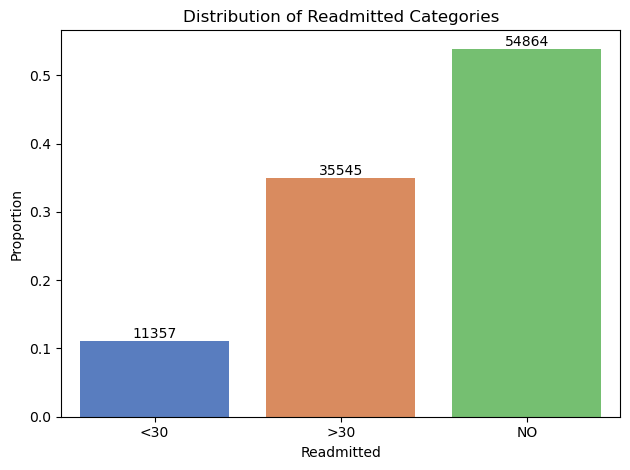

In [36]:
# Set the color palette
palette = sns.color_palette("muted", n_colors=len(readmit_order))

# Calculate counts and proportions of each category
readmit_counts = df_clean['readmitted'].value_counts(sort=False)  # Counts
readmit_proportions = readmit_counts / readmit_counts.sum()  # Proportions

# Plot the distribution
fig, ax = plt.subplots()
sns.barplot(
    x=readmit_proportions.index, 
    y=readmit_proportions.values, 
    hue=readmit_proportions.index,
    palette=palette, 
    ax=ax
)

# Add titles and labels
ax.set_title('Distribution of Readmitted Categories')
ax.set_xlabel('Readmitted')
ax.set_ylabel('Proportion')

# Add counts as labels on top of each bar
for bar, count in zip(ax.patches, readmit_counts.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate
        bar.get_height(),                  # y-coordinate (bar height)
        f'{count}',                        # Text label
        ha='center', va='bottom',         # Center alignment
        fontsize=10
    )

plt.tight_layout()
# plt.savefig(f'plots/barplot_readmitted.png', bbox_inches="tight") 
plt.show()

#### 3.4.2 Numerical features

This plots the distribution of each numerical variable split by response class. A histogram (or kernel density plot) and boxplots are plotted to get a visual sense of each variable.

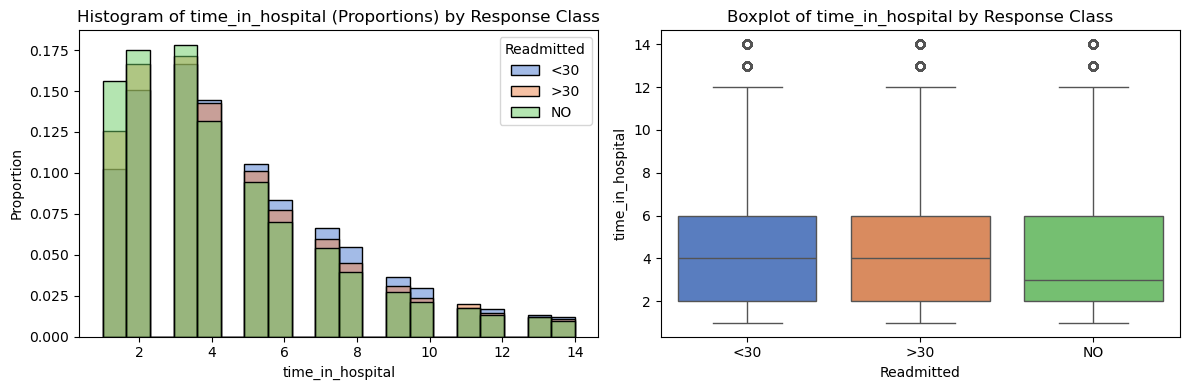

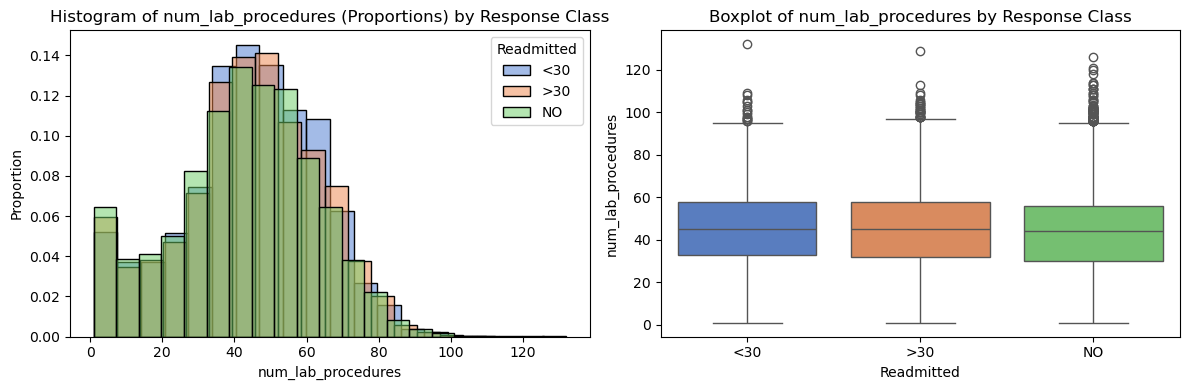

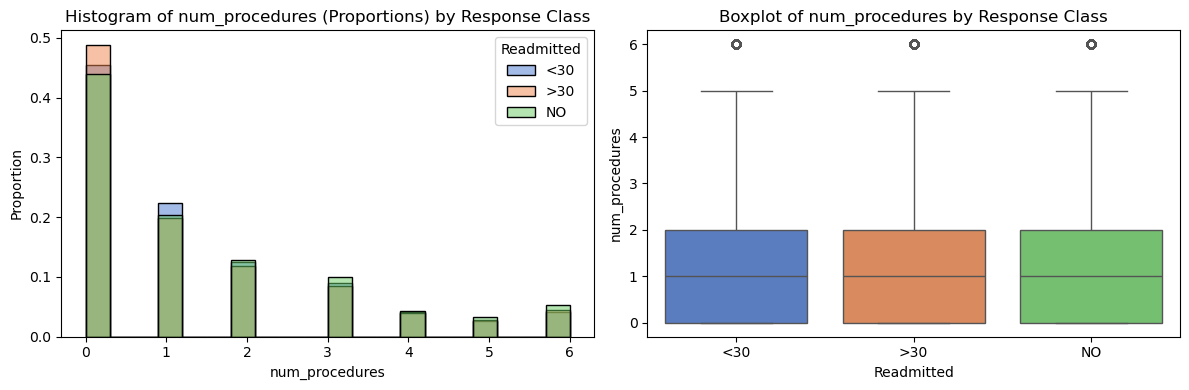

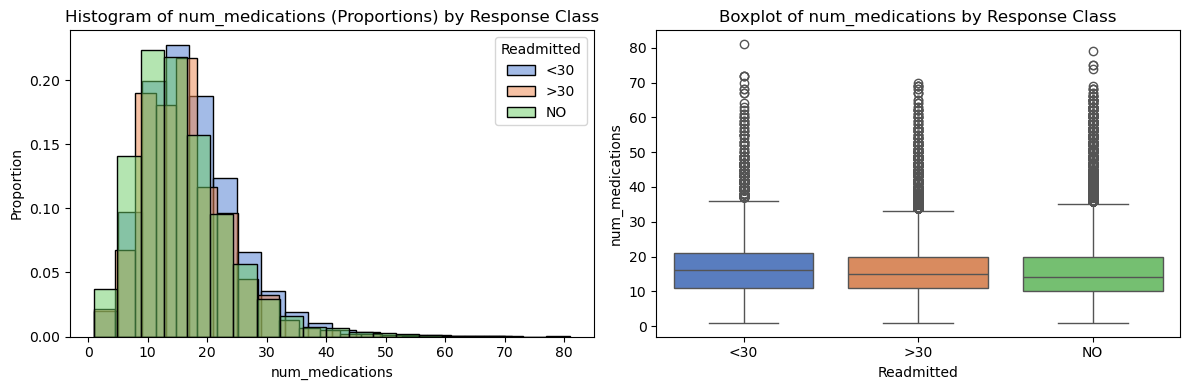

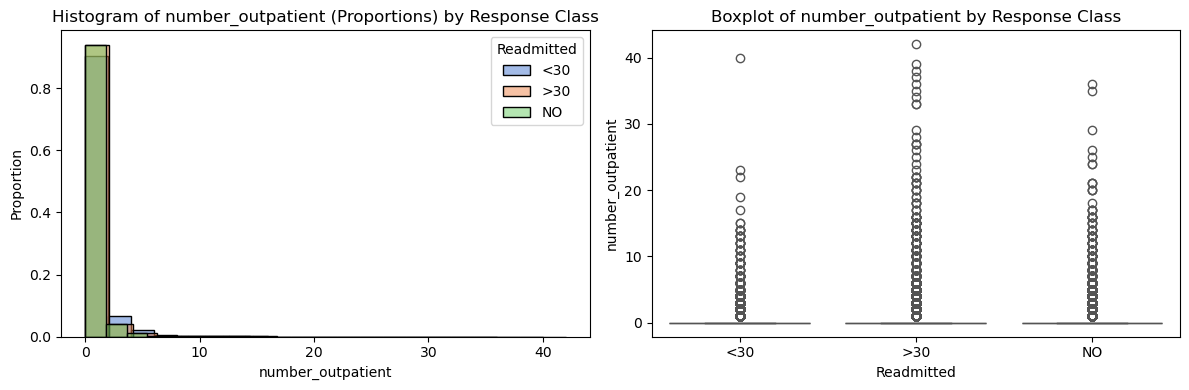

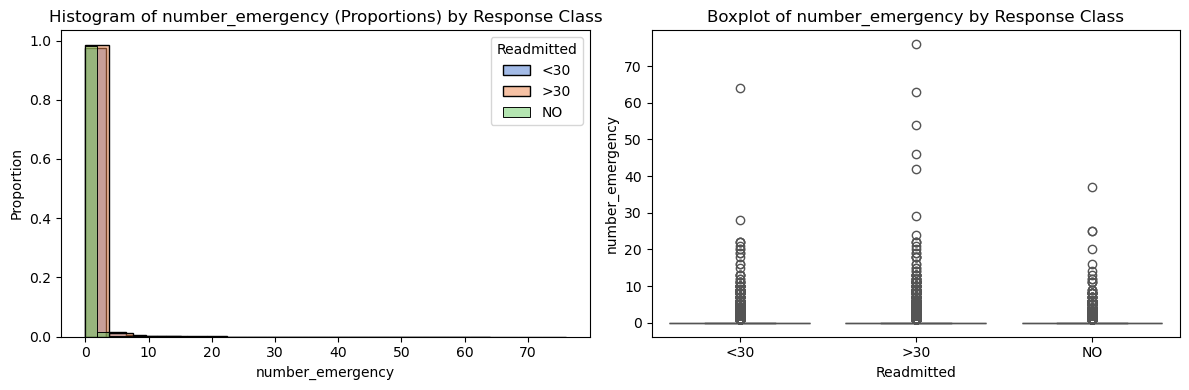

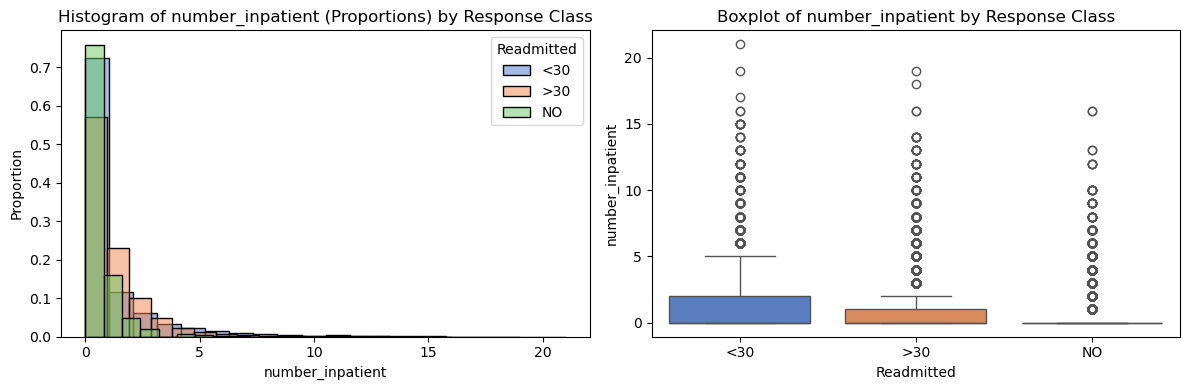

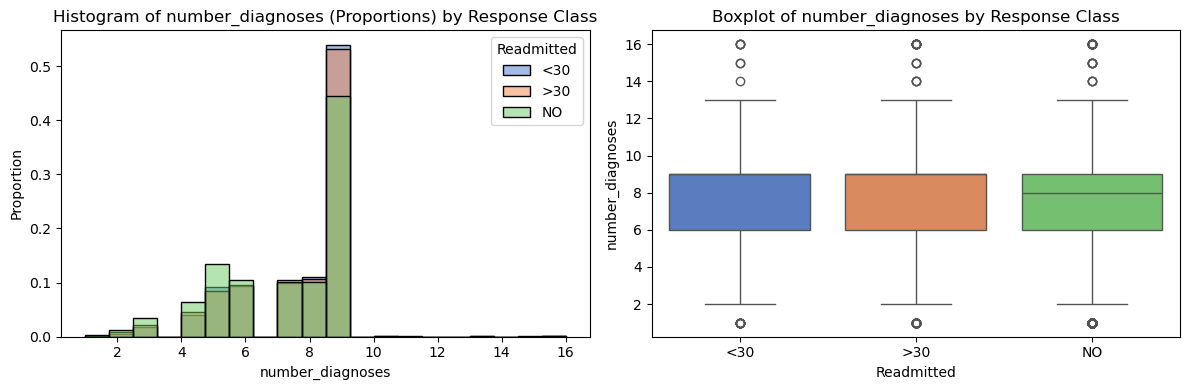

In [37]:
# List of numeric columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Set the color palette
palette = sns.color_palette("muted", n_colors=len(readmit_order))

# Generate plots for each numeric column
for col in numeric_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Histogram with proportions
    for idx, category in enumerate(readmit_order):
        subset = df_clean[df_clean['readmitted'] == category]
        sns.histplot(subset[col], bins=20, color=palette[idx], label=category, alpha=0.5, stat="probability", ax=axes[0])

    axes[0].set_title(f"Histogram of {col} (Proportions) by Response Class")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Proportion')
    axes[0].legend(title='Readmitted')

    # OR Kernel Density Plot
    # for idx, category in enumerate(readmit_order):
    #     subset = df_clean[df_clean['readmitted'] == category]
    #     sns.kdeplot(subset[col], fill=True, color=palette[idx], label=category, alpha=0.5, ax=axes[0])

    # axes[0].set_title(f"Kernel Density Plot of {col} by Response Class")
    # axes[0].set_xlabel(col)
    # axes[0].set_ylabel('Density')
    # axes[0].legend(title='Readmitted')

    # Boxplot
    sns.boxplot(data=df_clean, x='readmitted', y=col, hue='readmitted', palette=palette[:len(readmit_order)], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col} by Response Class")
    axes[1].set_xlabel('Readmitted')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    # plt.savefig(f'plots/plot_{col}_by_readmitted.png', bbox_inches="tight") 
    plt.show()

In [38]:
# This is to get a sense of the importance of a variable in target class separation.

# Group numerical variables by `readmitted` and view some summary stats

# Split the numerical columns into two groups
split_point = len(numeric_cols) // 2
numeric_cols_part1 = numeric_cols[:split_point]
numeric_cols_part2 = numeric_cols[split_point:]

# Group numerical variables (first half) by `readmitted` and calculate summary stats
aggregated_numstats1 = (
    df_clean.groupby('readmitted', observed=False)[numeric_cols_part1]
    .agg(['mean', 'std', 'median'])
    .loc[['<30', '>30', 'NO']]  # Reorder rows for readability
)

# Group numerical variables (second half) by `readmitted` and calculate summary stats
aggregated_numstats2 = (
    df_clean.groupby('readmitted', observed=False)[numeric_cols_part2]
    .agg(['mean', 'std', 'median'])
    .loc[['<30', '>30', 'NO']]
)

print("Part 1: Summary statistics for the first group of numerical variables")
aggregated_numstats1

Part 1: Summary statistics for the first group of numerical variables


time_in_hospital                  num_lab_procedures             \
                       mean       std median               mean        std   
readmitted                                                                   
<30                4.768249  3.028165    4.0          44.226028  19.276087   
>30                4.495541  2.988064    4.0          43.836601  19.567515   
NO                 4.254429  2.964964    3.0          42.381598  19.796262   

                  num_procedures                  num_medications            \
           median           mean       std median            mean       std   
readmitted                                                                    
<30          45.0       1.280884  1.635992    1.0       16.903143  8.096696   
>30          45.0       1.249599  1.669536    1.0       16.282768  7.618829   
NO           44.0       1.410305  1.739693    1.0       15.670367  8.427628   

                   
           median  
readmitted         
<30          16.0  
>30          15.0  
NO           14.0

In [39]:
print("\nPart 2: Summary statistics for the second group of numerical variables")
aggregated_numstats2


Part 2: Summary statistics for the second group of numerical variables


number_outpatient                  number_emergency            \
                        mean       std median             mean       std   
readmitted                                                                 
<30                 0.436911  1.302788    0.0         0.357313  1.370384   
>30                 0.496329  1.544047    0.0         0.283669  1.194989   
NO                  0.273112  1.030704    0.0         0.109216  0.523609   

                  number_inpatient                  number_diagnoses  \
           median             mean       std median             mean   
readmitted                                                             
<30           0.0         1.224003  1.954577    0.0         7.692789   
>30           0.0         0.838993  1.393265    0.0         7.646898   
NO            0.0         0.381963  0.864301    0.0         7.221366   

                             
                 std median  
readmitted                   
<30         1.773477    9.0  
>30         1.812078    9.0  
NO          2.017054    8.0

- There isn't obvious class separation in the numerical variables. However, looking at the graphs and summary statistics, there does appear to be some difference in the following features.  
  - time_in_hospital
  - num_lab_procedures
  - num_medications
  - number_emergency
  - number_inpatient
  - number_diagnoses

#### 3.4.3 Categorical features

This plots the percentages of each readmitted class within the levels of each categorical variables in bar plots. Only the 12 most frequency categorical levels are displayed. It helps us get a sense of if and how the distribution of each response class changes between categorical levels.

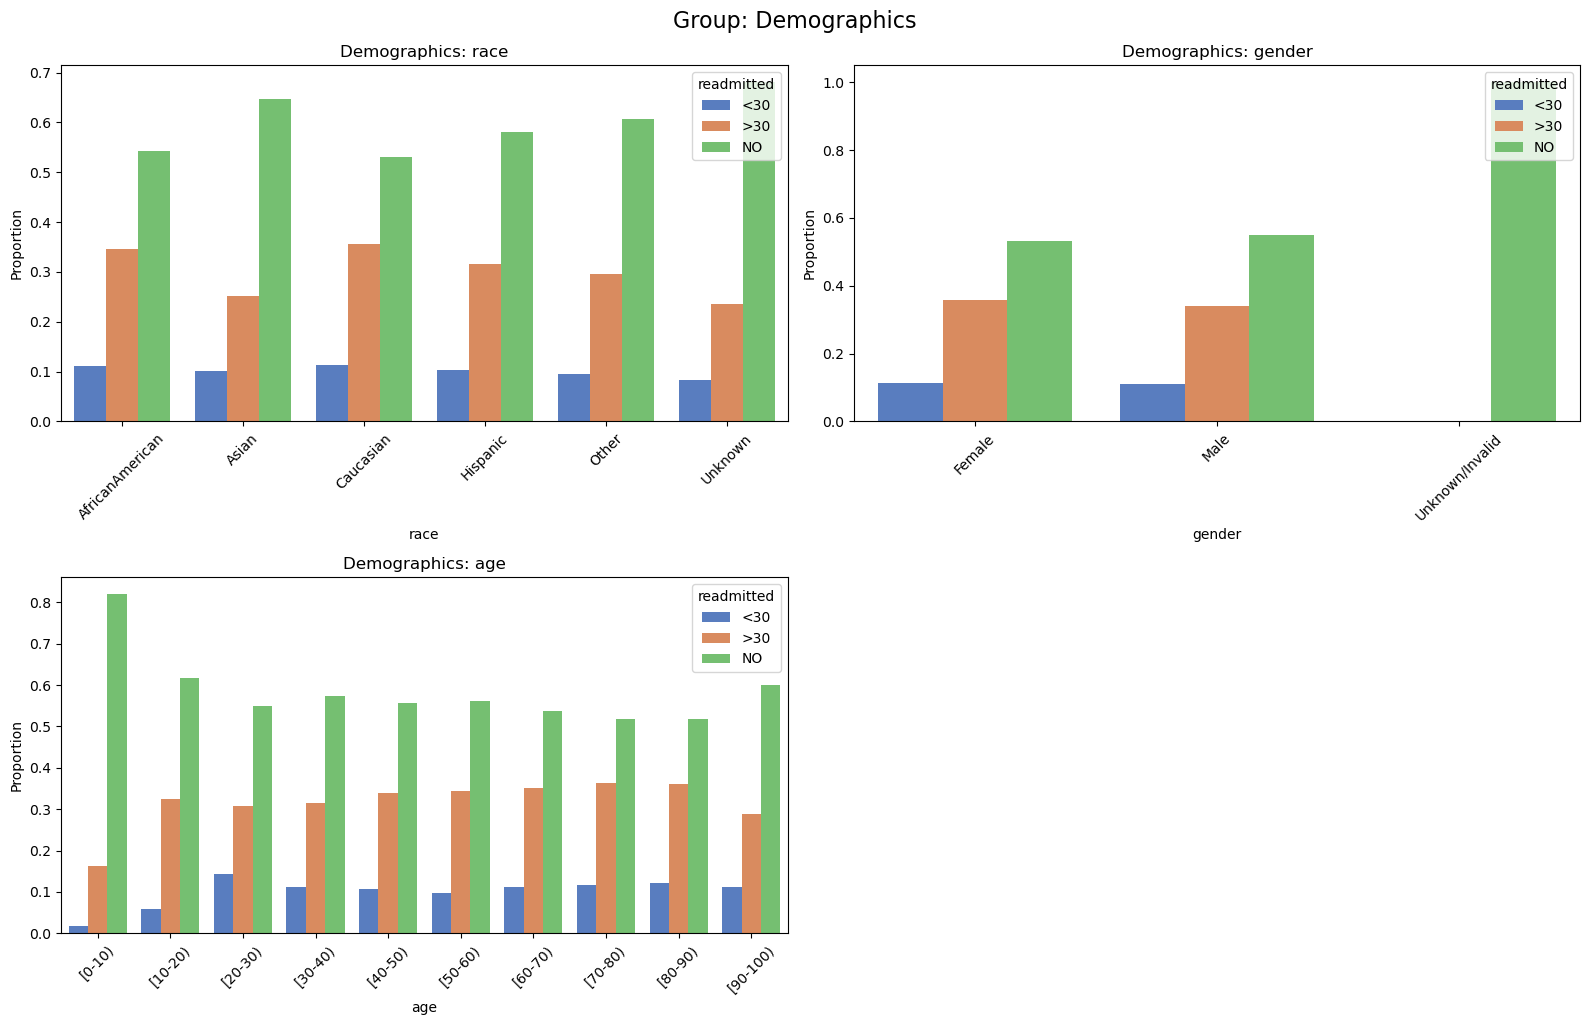

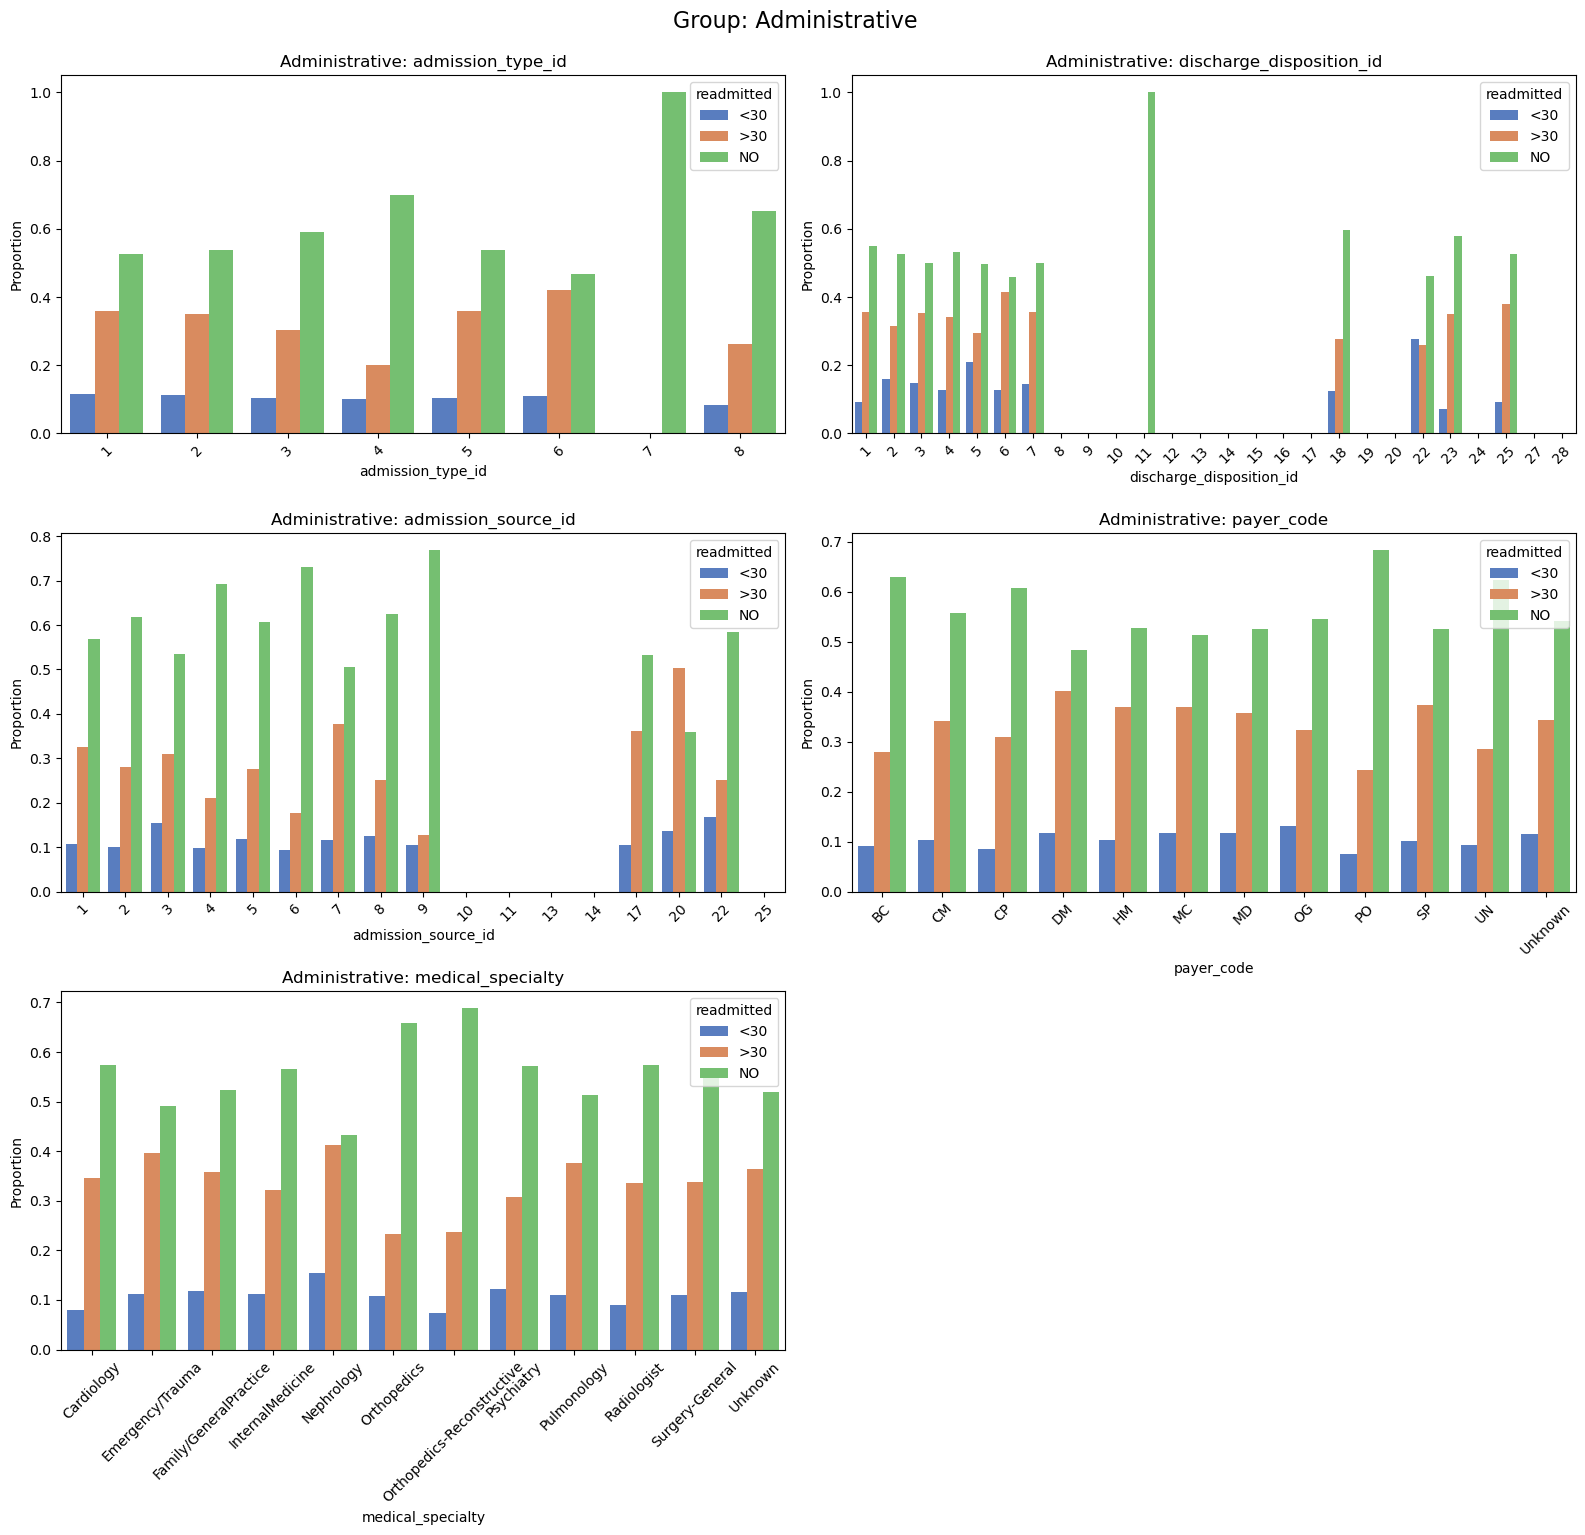

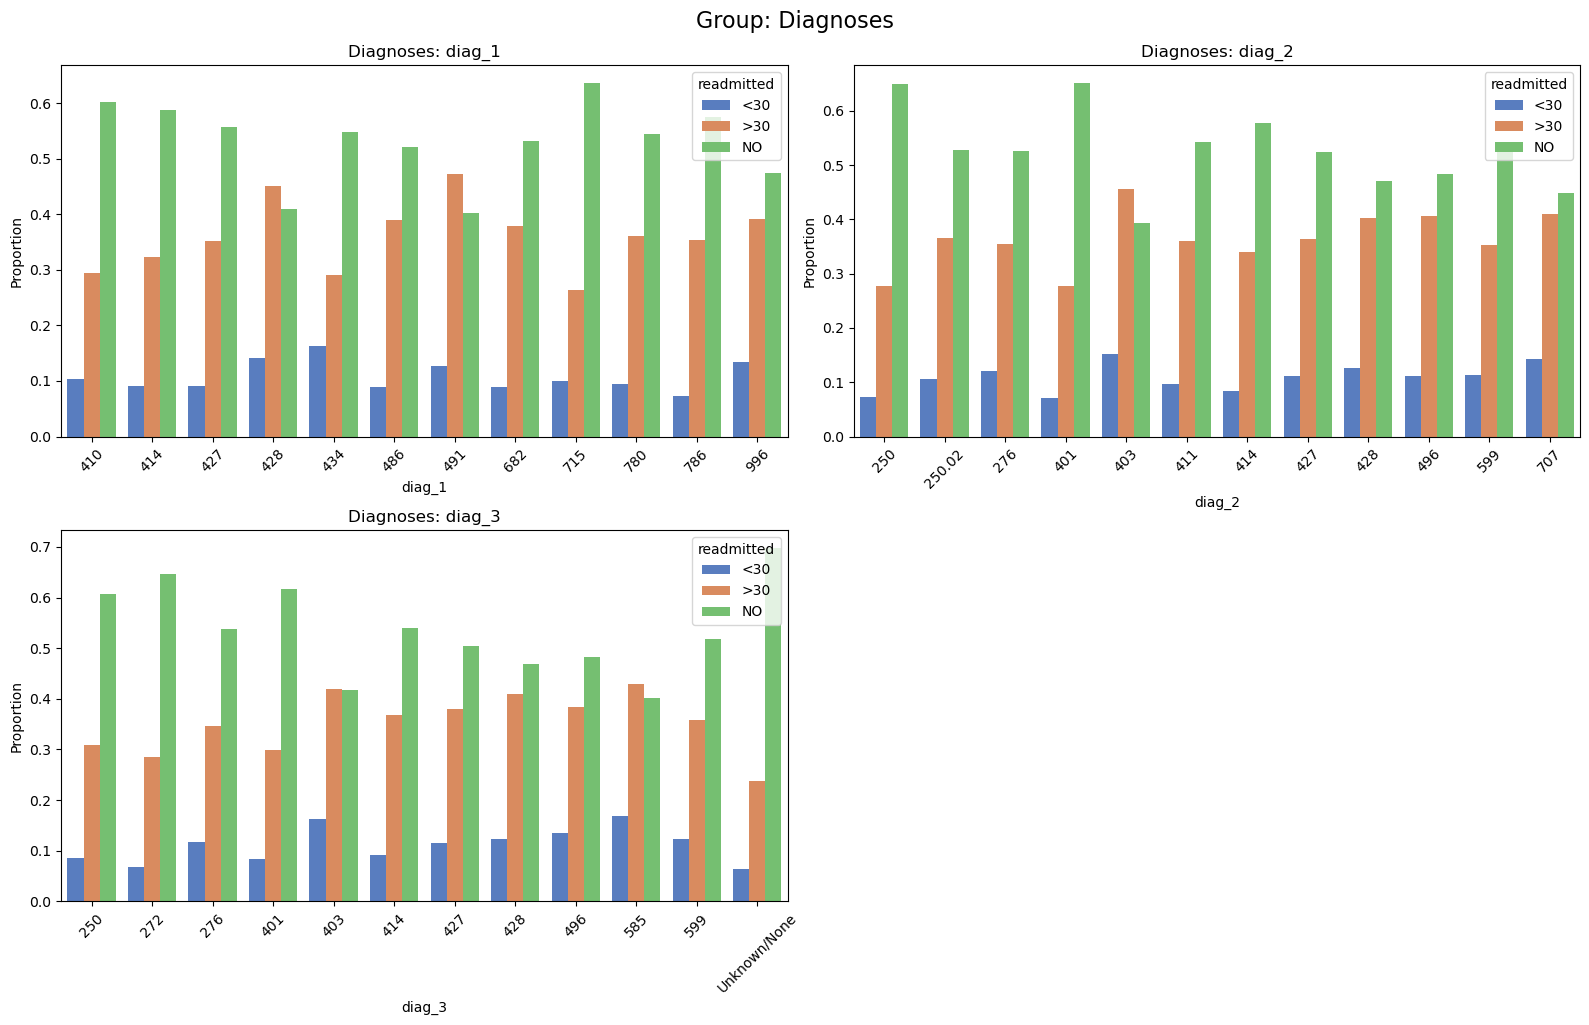

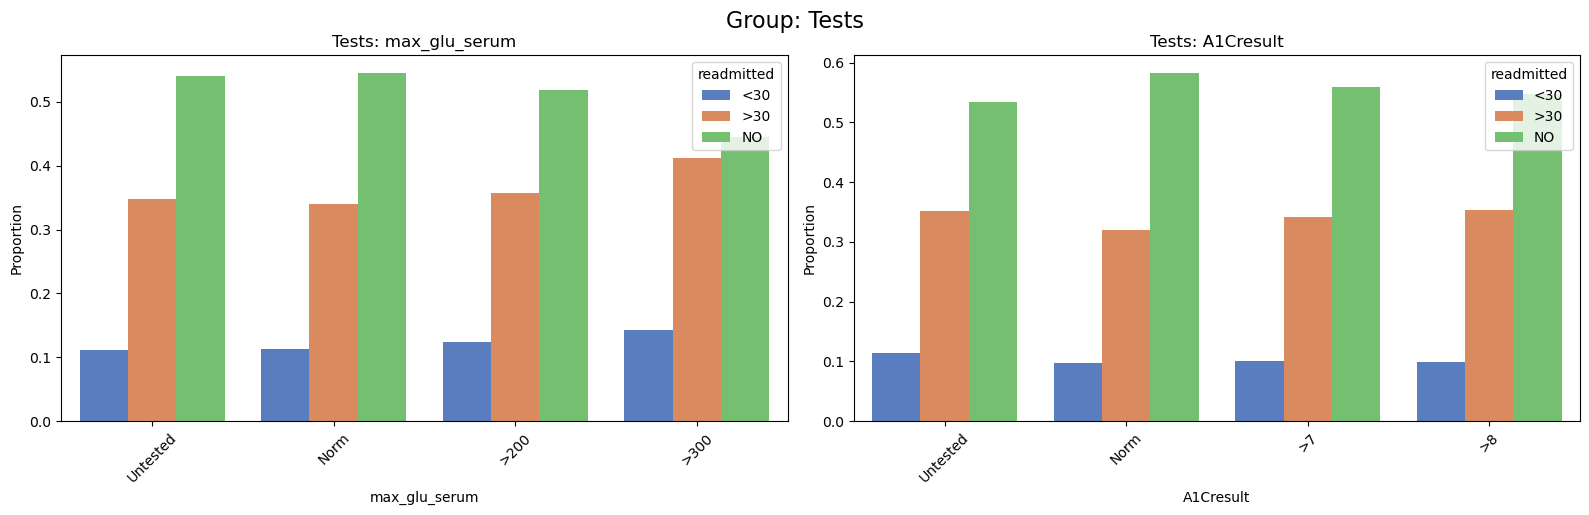

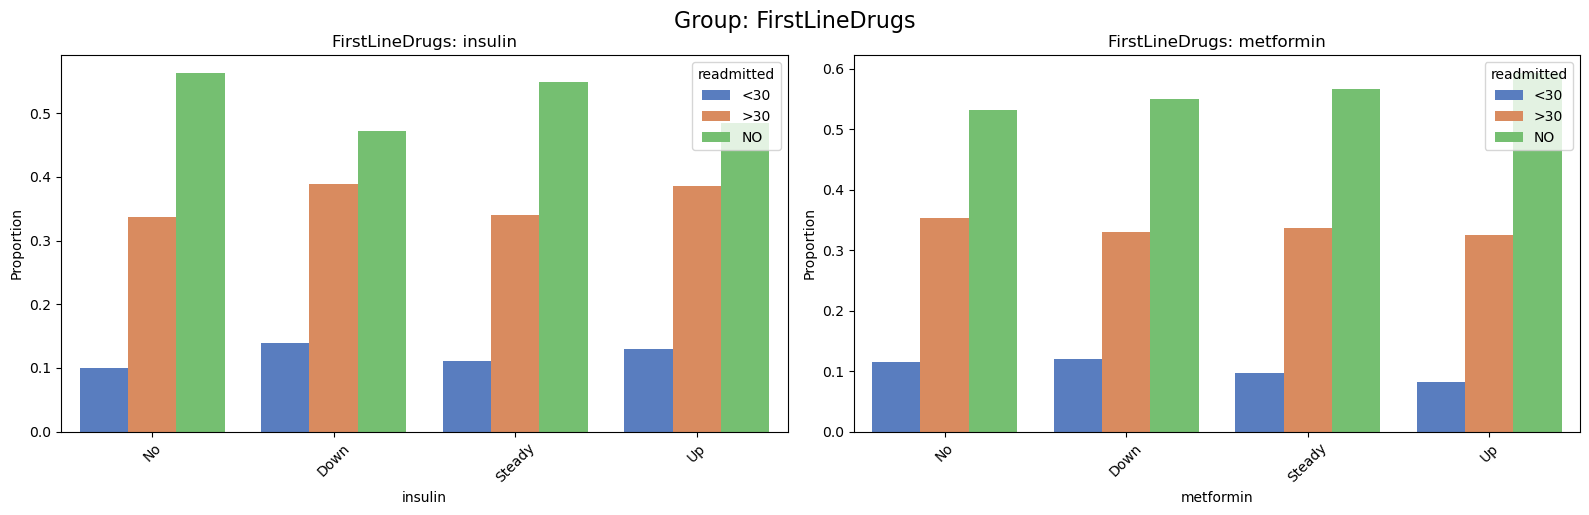

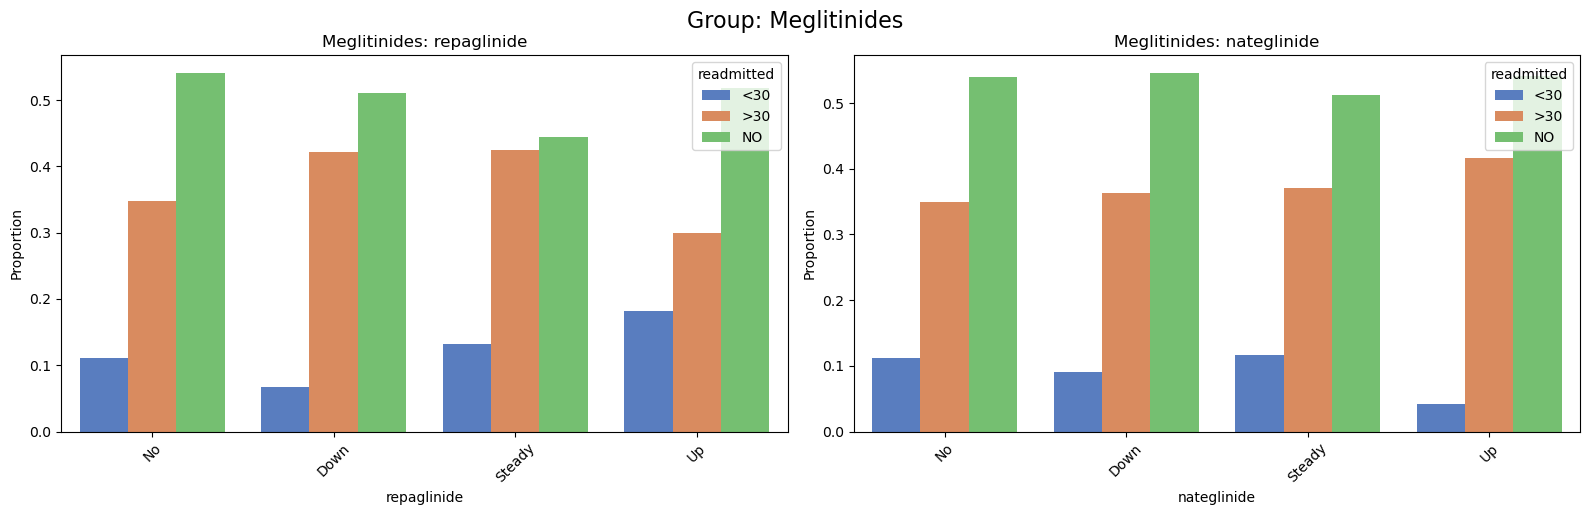

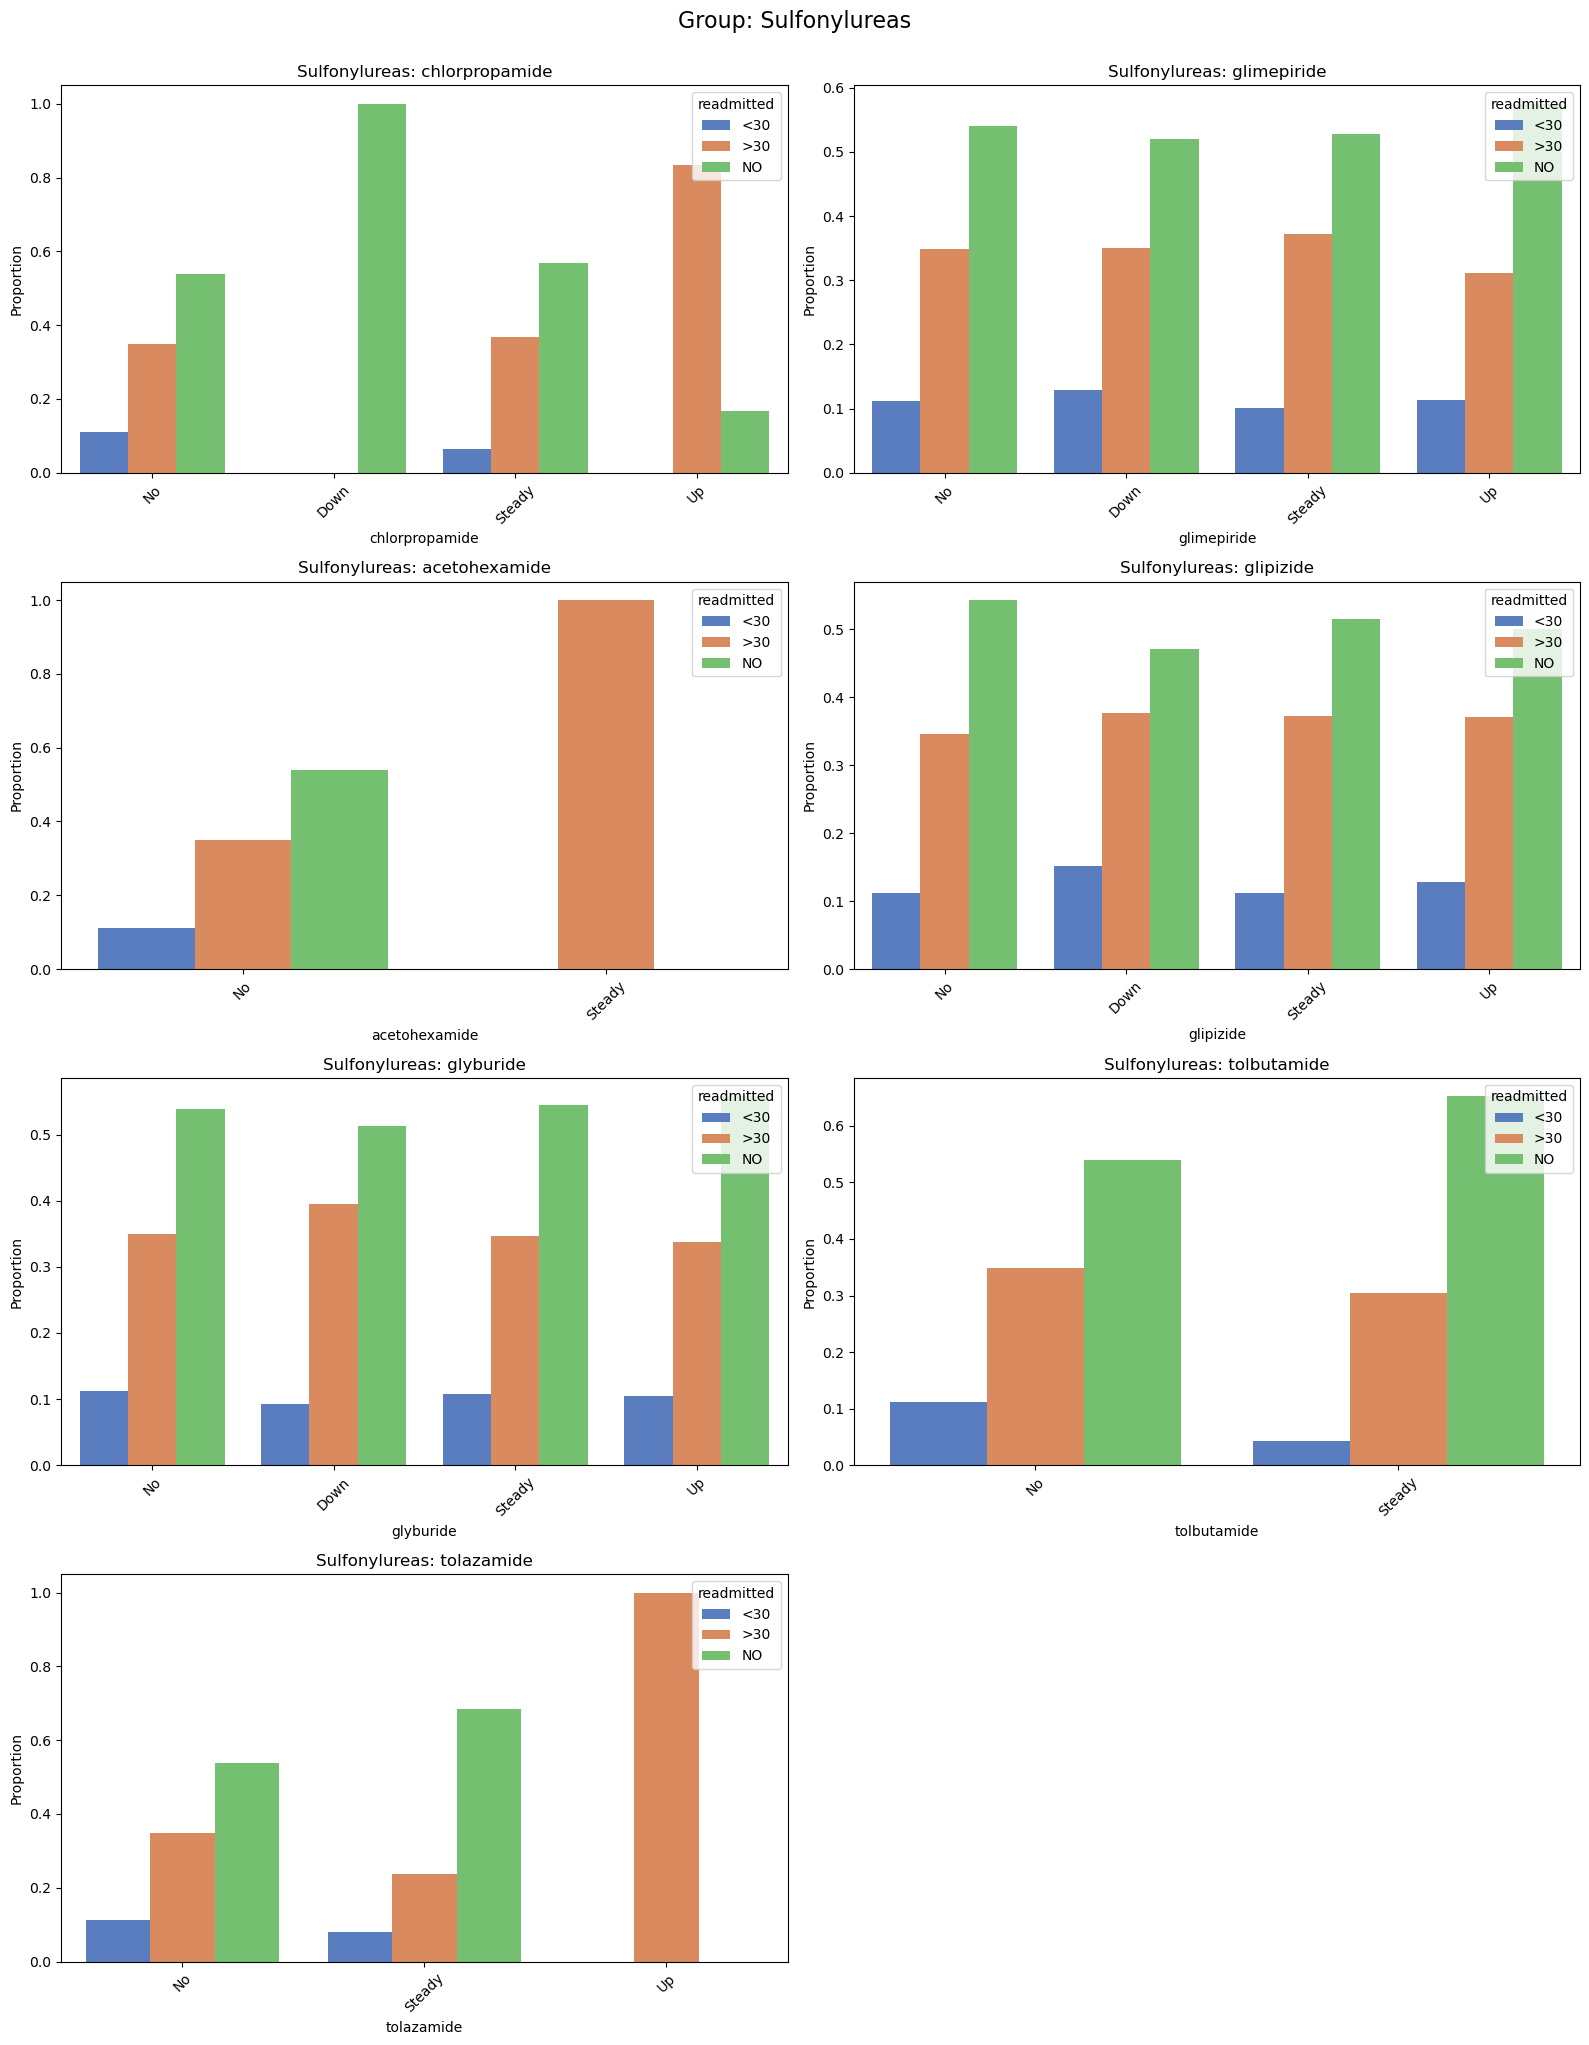

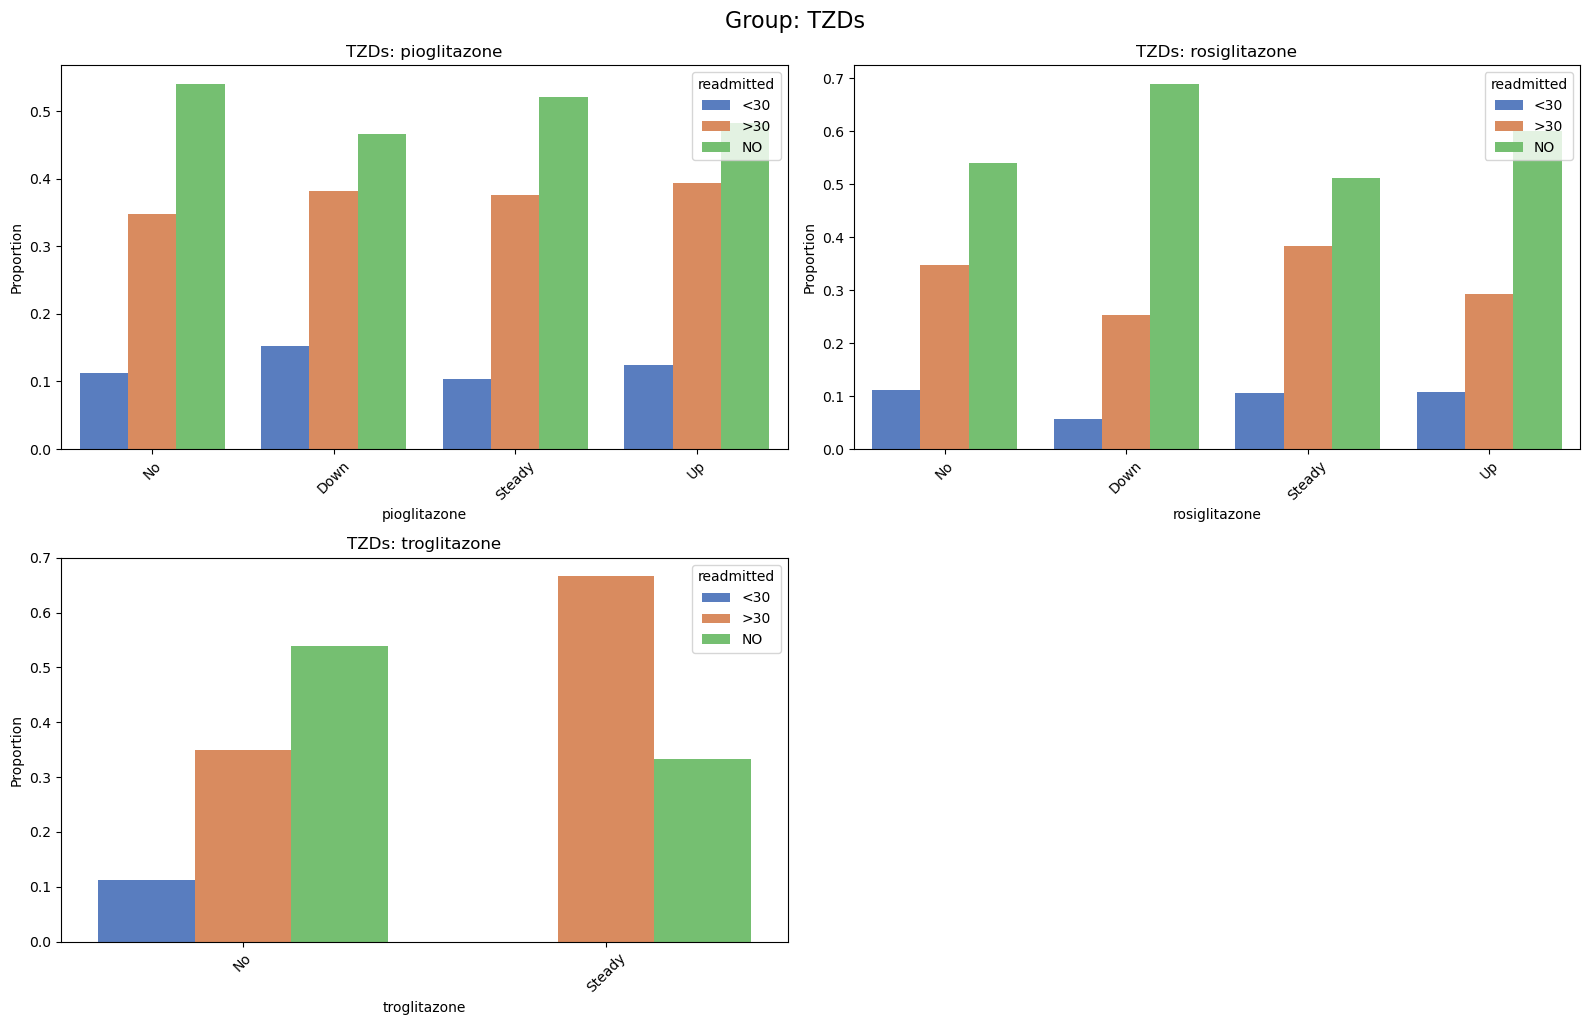

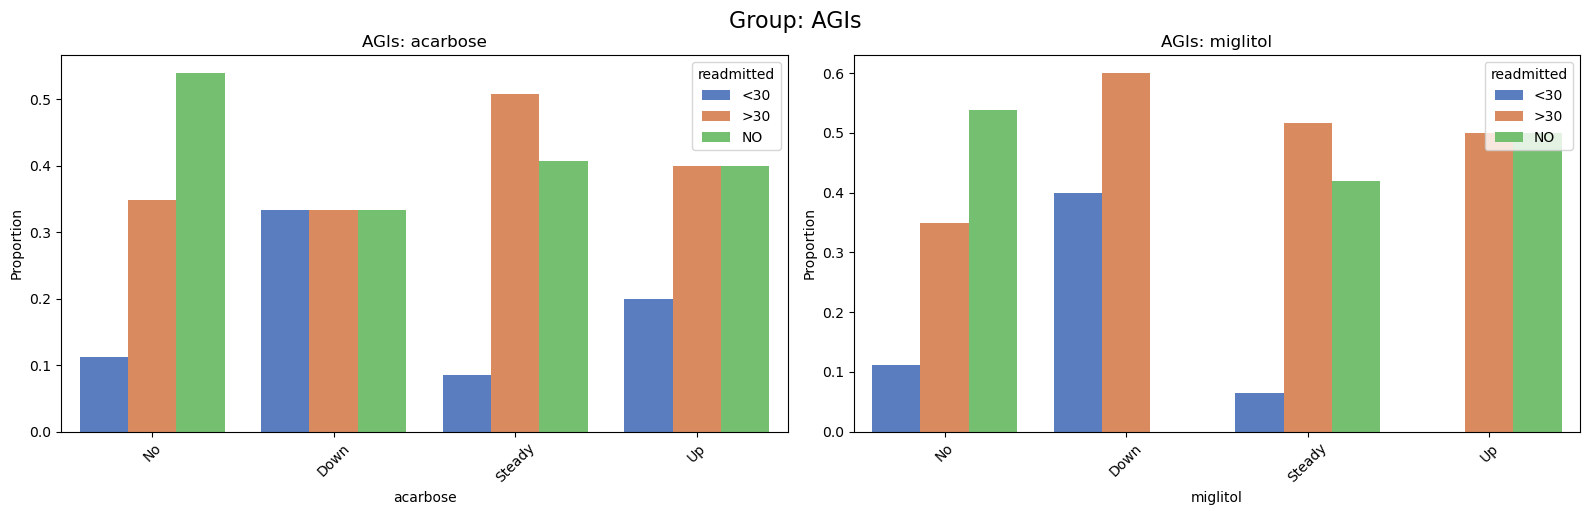

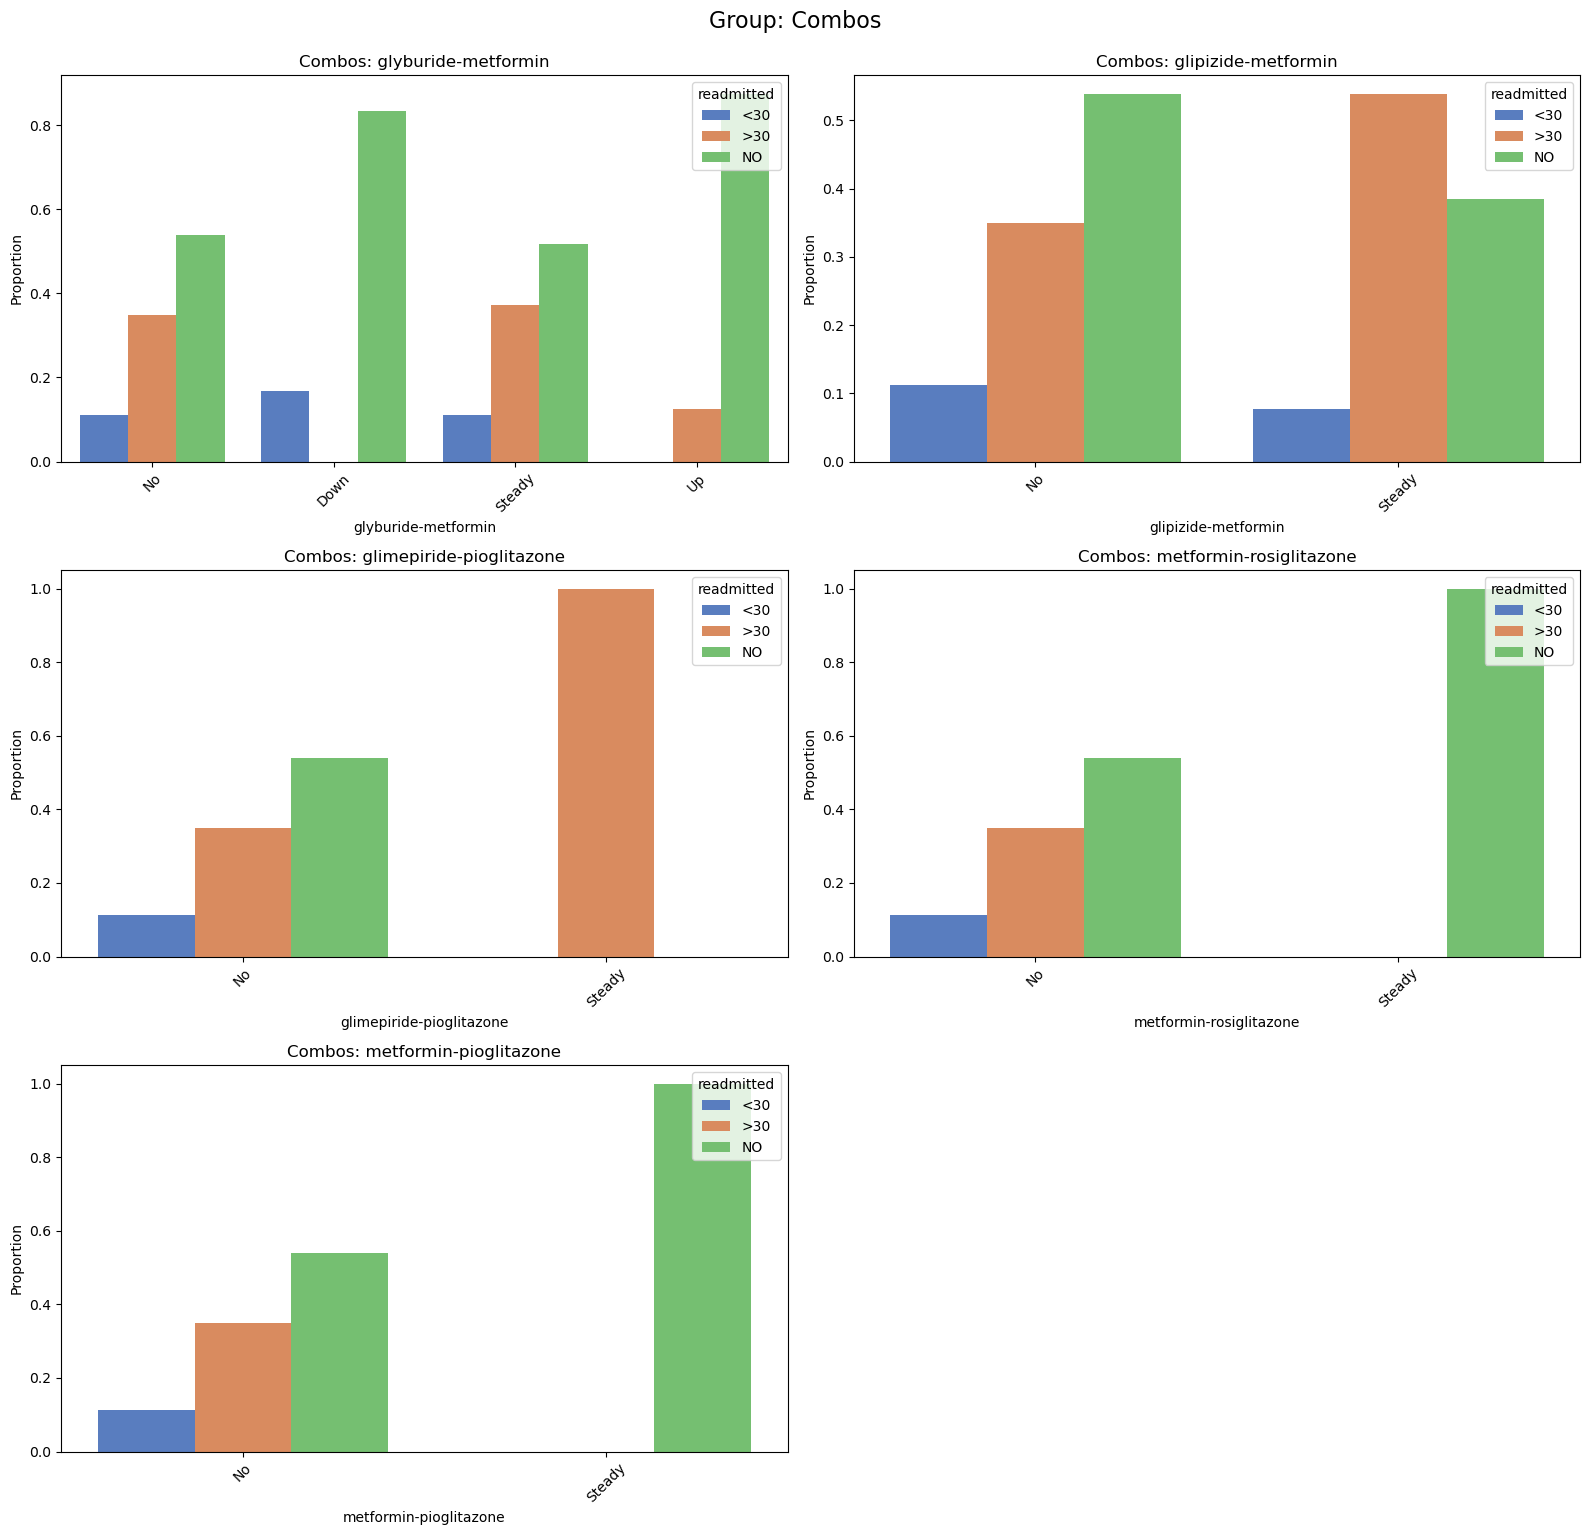

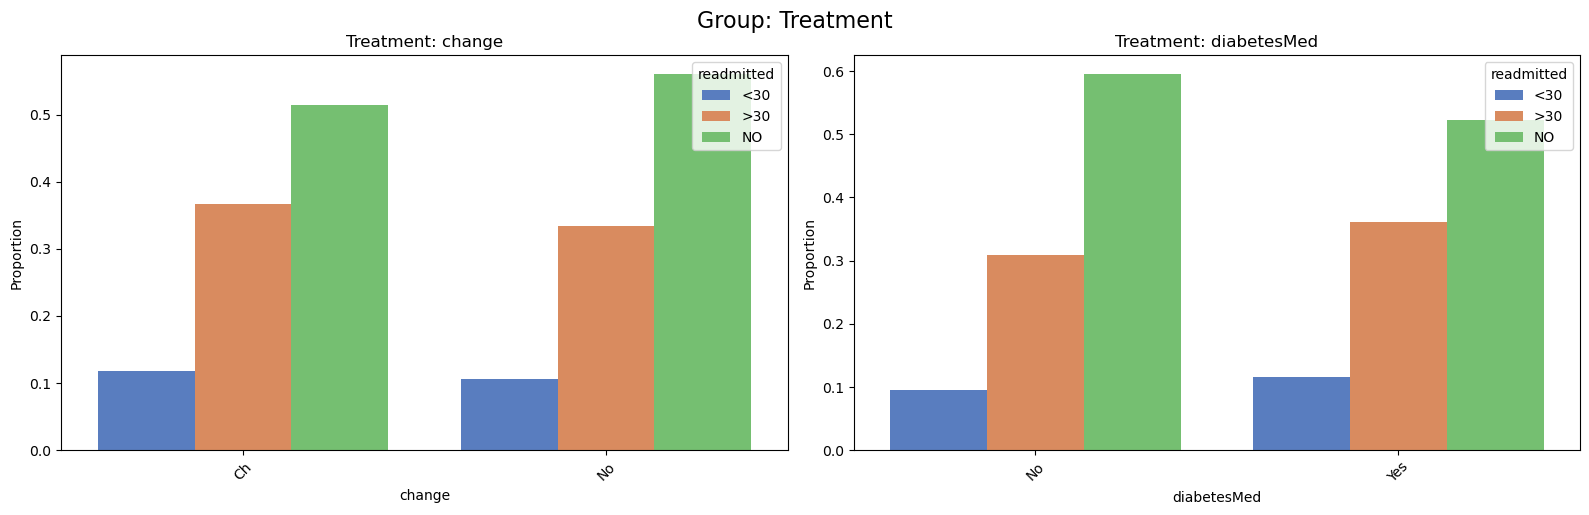

In [40]:
# Set the color palette
palette = sns.color_palette("muted", n_colors=len(readmit_order))

def calculate_proportions(df, catvar, response):
    """
    Calculate proportions of response classes for each level of a categorical variable.
    """
    # Count occurrences of each combination of catvar and response
    counts = df.groupby([catvar, response], observed=False).size().reset_index(name='count')
    
    # Calculate proportions within each level of the categorical variable
    counts['proportion'] = counts.groupby(catvar, observed=False)['count'].transform(lambda x: x / x.sum())
    
    return counts

def plot_categorical_proportions(df, groups, response, ncols=2, top_n=12, show_empty=True):
    """
    Create bar plots of proportions for categorical variables by response class.
    """
    for group_name, variables in groups.items():
        # Number of rows needed
        nrows = -(-len(variables) // ncols)  # Ceiling division
        
        # Create subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
        axes = axes.flatten()  # Flatten axes for easy iteration
        
        # Plot each variable in the group
        for i, var in enumerate(variables):
            if var in df.columns:  # Check if variable exists in DataFrame
                # Calculate proportions
                proportions = calculate_proportions(df, var, response)
                
                # Optionally exclude empty categories
                if not show_empty:
                    # Remove rows with zero counts
                    proportions = proportions[proportions['count'] > 0]

                    # Dynamically adjust categories to remove unused ones
                    if isinstance(proportions[var].dtype, pd.CategoricalDtype):
                        proportions[var] = proportions[var].cat.remove_unused_categories()

                # Limit to top_n categories by total count
                top_categories = proportions.groupby(var, observed=False)['count'].sum().nlargest(top_n).index
                plot_data = proportions[proportions[var].isin(top_categories)]
                
                # Bar plot
                sns.barplot(
                    data=plot_data,
                    x=var,
                    y='proportion',
                    hue=response,
                    palette=palette,
                    ax=axes[i]
                )
                axes[i].set_title(f'{group_name}: {var}', fontsize=12)
                axes[i].set_ylabel('Proportion')
                axes[i].set_xlabel(var)
                axes[i].tick_params(axis='x', rotation=45)
                axes[i].legend(title=response, loc='upper right')
            else:
                axes[i].set_visible(False)  # Hide empty plots
        
        # Hide unused axes
        for j in range(len(variables), len(axes)):
            axes[j].set_visible(False)
        
        # Adjust layout
        plt.tight_layout()
        plt.suptitle(f'Group: {group_name}', fontsize=16, y=1.02)  # Add a super title
        # plt.savefig(f'plots/plot_{group_name}_by_readmitted.png', bbox_inches="tight")
        plt.show()

# Grouping categorical variables for plotting
groups = {
    "Demographics": ['race', 'gender', 'age'], # excluded patient_nbr (and weight, which was dropped)
    "Administrative": ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty'],
    "Diagnoses": ['diag_1', 'diag_2', 'diag_3'],
    "Tests": ['max_glu_serum', 'A1Cresult'],
    "FirstLineDrugs": ['insulin', 'metformin'],
    "Meglitinides": ['repaglinide', 'nateglinide'],
    "Sulfonylureas": ['chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide'],
    "TZDs": ['pioglitazone', 'rosiglitazone', 'troglitazone'],
    "AGIs": ['acarbose', 'miglitol'],
    "Combos": ['glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'],
    "Treatment": ['change', 'diabetesMed']
}

# Call the function to create bar plots
plot_categorical_proportions(df_clean, groups, response='readmitted', ncols=2, top_n=12, show_empty=False)

- Comparing the trends between the response classes across categorical levels, there are no stand-out examples of class separation between levels. We also need to bear in mind that many of these features have a large imbalance in their categorical levels (e.g. many of the drug variables). However, there are some differences where it looks like feature level may be associate with response class. Examples include:
  - race
  - admission_type_id
  - discharge_disposition_id
  - admission_source_id
  - payer_code
  - medical_specialty
  - diag_1, diag_2, diag_3
  - max_glu_serum
  - nearly all the drug variables
  - change
  - diabetesMed

#### 3.4.4 Feature selection

Here, we want to do some feature selection to help get a sense of the most important features. First, we start by preprocessing categorical features, ordering the ordinal ones and then one-hot encoding. 

##### **A. Preprocessing**

In [41]:
# Preprocessing and dataset checks for LASSO feature selection
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create a copy of df_clean to avoid modifying the original dataframe
df_encoded = df_clean.copy()

# Define the order for drug variables
drug_order = {'No': 0, 'Down': 1, 'Steady': 2, 'Up': 3}

# List of drug-related variables
drug_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol', 
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']

# Apply the ordinal mapping to drug variables
for col in drug_columns:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map(drug_order)

# Encode the age ranges as ordinal
df_encoded['age'] = pd.Categorical(df_encoded['age'], categories=age_order, ordered=True).codes

# Preprocess diag_1, diag_2, diag_3 combining all 
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_encoded[col] = df_encoded[col].str.split('.').str[0]  # Drop decimals and digits after
# Group less frequent categories into other
for col in ['diag_1', 'diag_2', 'diag_3']:
    top_categories = df_encoded[col].value_counts().nlargest(20).index # without this this code took forever to run
    df_encoded[col] = df_encoded[col].apply(lambda x: x if x in top_categories else 'Other')

# # Replace NaNs in 'medical_specialty' and 'payer_code' with 'unknown'
# categorical_na_columns = ['medical_specialty', 'payer_code']
# for col in categorical_na_columns:
#     df_encoded[col] = df_encoded[col].fillna('unknown')

# Drop highly missing columns
columns_to_drop = ['patient_nbr', 'max_glu_serum', 'A1Cresult'] # weight is already dropped
df_encoded = df_encoded.drop(columns=columns_to_drop)

# Check for remaining missing values
# print("Missing values before dropping rows:")
# print(df_encoded.isnull().sum())

# Drop rows with NaN values
df_encoded = df_encoded.dropna()
# Or impute them with the mode (or use KNN imputer)
# for col in ['diag_1', 'diag_2', 'race']:
#     df_encoded[col] = df_encoded[col].fillna(df_encoded[col].mode()[0])

# Ensure the dataframe still has rows
if df_encoded.shape[0] == 0:
    raise ValueError("No rows left after dropping NaNs. Consider imputing missing values instead.")

# Check the shape of the final dataset
# print(f"Shape after preprocessing: {df_encoded.shape}")

# Define predictors (X) and response (y)
X = df_encoded.drop(columns=['readmitted'])  # Exclude the target variable
y = df_encoded['readmitted'].cat.codes  # Encode the target variable as 0, 1, 2

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Scale numeric features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ]
)

# Apply preprocessing to X
X_preprocessed = preprocessor.fit_transform(X)

# Check the shape of the preprocessed dataset
print(f"Preprocessed dataset shape: {X_preprocessed.shape}")

Preprocessed dataset shape: (101766, 295)


##### **B. LASSO penalized regression**

In [42]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=1234)

# Fit LASSO logistic regression (LogisticRegressionCV with L1 penalty)
lasso = LogisticRegressionCV(
    penalty='l1',  # LASSO penalty
    solver='saga',  # Supports L1 regularization
    Cs=np.logspace(-3, 3, 20),  # Lambda values (inverse of regularization strength)
    cv=5,  # 5-fold cross-validation
    scoring='neg_log_loss',  # Metric: log loss
    random_state=1234,
    max_iter=5000,
    n_jobs=-1 #Use all CPU cores
)

lasso.fit(X_train, y_train)

# Extract the best lambda (C is the inverse of lambda)
best_lambda = 1 / lasso.C_[0]
print(f"Best lambda (penalty strength): {best_lambda}")

# Extract the feature names
feature_names = (
    list(numeric_features) +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

# Extract the coefficients
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nLASSO Coefficients:")
print(coefficients)

# Identify features not pushed to zero
selected_features = coefficients[coefficients['Coefficient'] != 0]
print("\nSelected Features (Non-zero Coefficients):")
print(selected_features)

# Evaluate the LASSO model
y_pred = lasso.predict(X_test)
y_pred_proba = lasso.predict_proba(X_test)

print("\nModel Evaluation:")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Best lambda (penalty strength): 2.9763514416313193

LASSO Coefficients:
                                          Feature  Coefficient
50                    discharge_disposition_id_28     1.256386
39                    discharge_disposition_id_15     0.948760
100                  medical_specialty_Hematology     0.881117
45                    discharge_disposition_id_22     0.864539
101         medical_specialty_Hematology/Oncology     0.712073
..                                            ...          ...
114  medical_specialty_Orthopedics-Reconstructive    -0.218962
25                     discharge_disposition_id_1    -0.245820
116              medical_specialty_Otolaryngology    -0.272857
48                    discharge_disposition_id_25    -0.475038
46                    discharge_disposition_id_23    -0.742739

[295 rows x 2 columns]

Selected Features (Non-zero Coefficients):
                                          Feature  Coefficient
50                    discharge_dispositi

In [43]:
import re

# Separate numerical features before processing categorical ones
numeric_features = coefficients['Feature'][coefficients['Feature'].isin(X.select_dtypes(include=['int64', 'float64']).columns)]
categorical_features = coefficients['Feature'][~coefficients['Feature'].isin(numeric_features)]

# Apply regex to remove one-hot encoding suffixes only for categorical features
original_features = categorical_features.str.replace(r'_[^_]+$', '', regex=True)

# Combine the cleaned categorical features with the numerical features
unique_features = pd.concat([numeric_features, original_features]).unique()

print("Unique Original Features:")
print(unique_features)

# List of features in the dataset (from preprocessing)
dataset_features = X.columns

# Cleaned unique features (from LASSO coefficients)
lasso_unique_features = pd.Series(unique_features)

# Find common features
common_features = lasso_unique_features[lasso_unique_features.isin(dataset_features)]

# Find features in the dataset but not selected by LASSO
unused_features = pd.Series(dataset_features[~dataset_features.isin(lasso_unique_features)])

# # Print results
# print("Common Features (Selected by LASSO and Present in Dataset):")
# print(common_features)

print("\nUnused Features (Present in Dataset but NOT Selected by LASSO):")
print(unused_features)

Unique Original Features:
['number_inpatient' 'num_medications' 'number_emergency'
 'num_lab_procedures' 'time_in_hospital' 'num_procedures'
 'number_outpatient' 'number_diagnoses' 'discharge_disposition_id'
 'medical_specialty' 'diag_1' 'diag_3' 'glipizide' 'diag_2' 'payer_code'
 'metformin' 'admission_source_id' 'insulin' 'glyburide' 'nateglinide'
 'acarbose' 'miglitol' 'troglitazone' 'tolazamide' 'glyburide-metformin'
 'glipizide-metformin' 'glimepiride-pioglitazone'
 'metformin-rosiglitazone' 'metformin-pioglitazone' 'change' 'diabetesMed'
 'rosiglitazone' 'glimepiride' 'repaglinide' 'chlorpropamide'
 'acetohexamide' 'tolbutamide' 'pioglitazone' 'admission_type_id' 'race'
 'gender']

Unused Features (Present in Dataset but NOT Selected by LASSO):
0    age
dtype: object


Penalized regression with LASSO only removes age.  

Next we will try Random Forest.

##### **C. Random forest for variable importance**

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf = RandomForestClassifier(random_state=1234)
rf.fit(X_train, y_train)

# Get feature importance
importances = rf.feature_importances_

# Combine feature names and importances
# Retrieve feature names from the preprocessor
numeric_features = list(numeric_features)
categorical_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out())

all_feature_names = numeric_features + categorical_features

# Ensure the lengths match
if len(all_feature_names) != len(importances):
    raise ValueError(f"Mismatch between feature names ({len(all_feature_names)}) and importances ({len(importances)}).")

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importance:")
print(feature_importances)

# Set a threshold for importance (e.g., remove features with very low importance)
threshold = 0.01  # Keep features with importance > 1%
selected_features = feature_importances[feature_importances['Importance'] > threshold]

print("\nSelected Features:")
print(selected_features)

# Filter X_train and X_test based on selected features
selected_indices = selected_features.index
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

Feature Importance:
                                    Feature    Importance
1                           num_medications  6.914669e-02
3                        num_lab_procedures  6.335111e-02
0                          number_inpatient  4.773139e-02
6                         number_outpatient  3.891731e-02
7                          number_diagnoses  3.463782e-02
..                                      ...           ...
63                   admission_source_id_14  6.224589e-08
134  medical_specialty_Psychiatry-Addictive  0.000000e+00
132            medical_specialty_Proctology  0.000000e+00
128          medical_specialty_Perinatology  0.000000e+00
290                metformin-pioglitazone_2  0.000000e+00

[295 rows x 2 columns]

Selected Features:
                        Feature  Importance
1               num_medications    0.069147
3            num_lab_procedures    0.063351
0              number_inpatient    0.047731
6             number_outpatient    0.038917
7              numbe

In [45]:
import re

# Retrieve feature names from the preprocessor
# For categorical features, OneHotEncoder creates feature names based on categories
categorical_features_rf = preprocessor.named_transformers_['cat'].get_feature_names_out()
numeric_features_rf = list(numeric_features)

# Combine numeric and categorical feature names
all_feature_names_rf = numeric_features_rf + list(categorical_features_rf)

# Ensure the lengths match with the importance values
if len(all_feature_names_rf) != len(importances):
    raise ValueError(f"Mismatch between feature names ({len(all_feature_names_rf)}) and importances ({len(importances)}).")

# Map selected feature indices back to their names
selected_features_rf = feature_importances[feature_importances['Importance'] > threshold]
selected_feature_indices = selected_features_rf.index
selected_feature_names = [all_feature_names_rf[i] for i in selected_feature_indices]

# Separate numerical and categorical selected features
selected_numeric_features = [feature for feature in selected_feature_names if feature in numeric_features_rf]
selected_categorical_features = [feature for feature in selected_feature_names if feature not in numeric_features_rf]

# Apply regex to clean one-hot encoded names for categorical features only
cleaned_selected_categorical_features = [re.sub(r'_[^_]+$', '', feature) for feature in selected_categorical_features]

# Combine cleaned categorical features with numeric features
unique_selected_features = pd.Series(selected_numeric_features + cleaned_selected_categorical_features).unique()

print("Unique Original Features from Random Forest:")
print(unique_selected_features)

# Compare with dataset features
dataset_features_rf = list(X.columns)

# Find common features
common_rf_features = [feature for feature in unique_selected_features if feature in dataset_features_rf]

# Find unused features in the dataset
unused_rf_features = [feature for feature in dataset_features_rf if feature not in unique_selected_features]

# Print results
print("\nCommon Features (Selected by Random Forest and Present in Dataset):")
print(common_rf_features)

print("\nUnused Features (Present in Dataset but NOT Selected by Random Forest):")
print(unused_rf_features)


Unique Original Features from Random Forest:
['num_medications' 'num_lab_procedures' 'number_inpatient'
 'number_outpatient' 'number_diagnoses' 'number_emergency'
 'time_in_hospital' 'num_procedures' 'diag_3' 'gender' 'diag_1'
 'medical_specialty' 'diag_2' 'payer_code' 'race'
 'discharge_disposition_id']

Common Features (Selected by Random Forest and Present in Dataset):
['num_medications', 'num_lab_procedures', 'number_inpatient', 'number_outpatient', 'number_diagnoses', 'number_emergency', 'time_in_hospital', 'num_procedures', 'diag_3', 'gender', 'diag_1', 'medical_specialty', 'diag_2', 'payer_code', 'race', 'discharge_disposition_id']

Unused Features (Present in Dataset but NOT Selected by Random Forest):
['age', 'admission_type_id', 'admission_source_id', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insuli

The important variables change a bit when this is run. It might be worth running it a few times and comparing variable importance. However, after preprocessing the data, there are ~16 selected features. Age, the admission variables, and the medication variables are mostly excluded. 

#### 3.4.5 Important features

##### ***Visualize the most important attributes appropriately (at least 5 attributes). Important: Provide an interpretation for each chart. Explain for each attribute why the chosen visualization is appropriate.***

*Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).*

This replots several of the variables that seemed important based on summary statistics, the plots above, and the random forest variable importance. To see the relationships a little differently, violin plots and stacked bar plots are used. Violin plots are appropriate visualizations for continuous variables. In addition to the median and IQR information also provide by boxplots, they reveal where data points are clustered thoroughout the distribution. The stacked bar plots are appropriate for categorical variables because they provide a side-by-side comparison of the proportion of each response class within each categorical level of the variable. This side-by-side visualization helps display where category may influence the response class.  

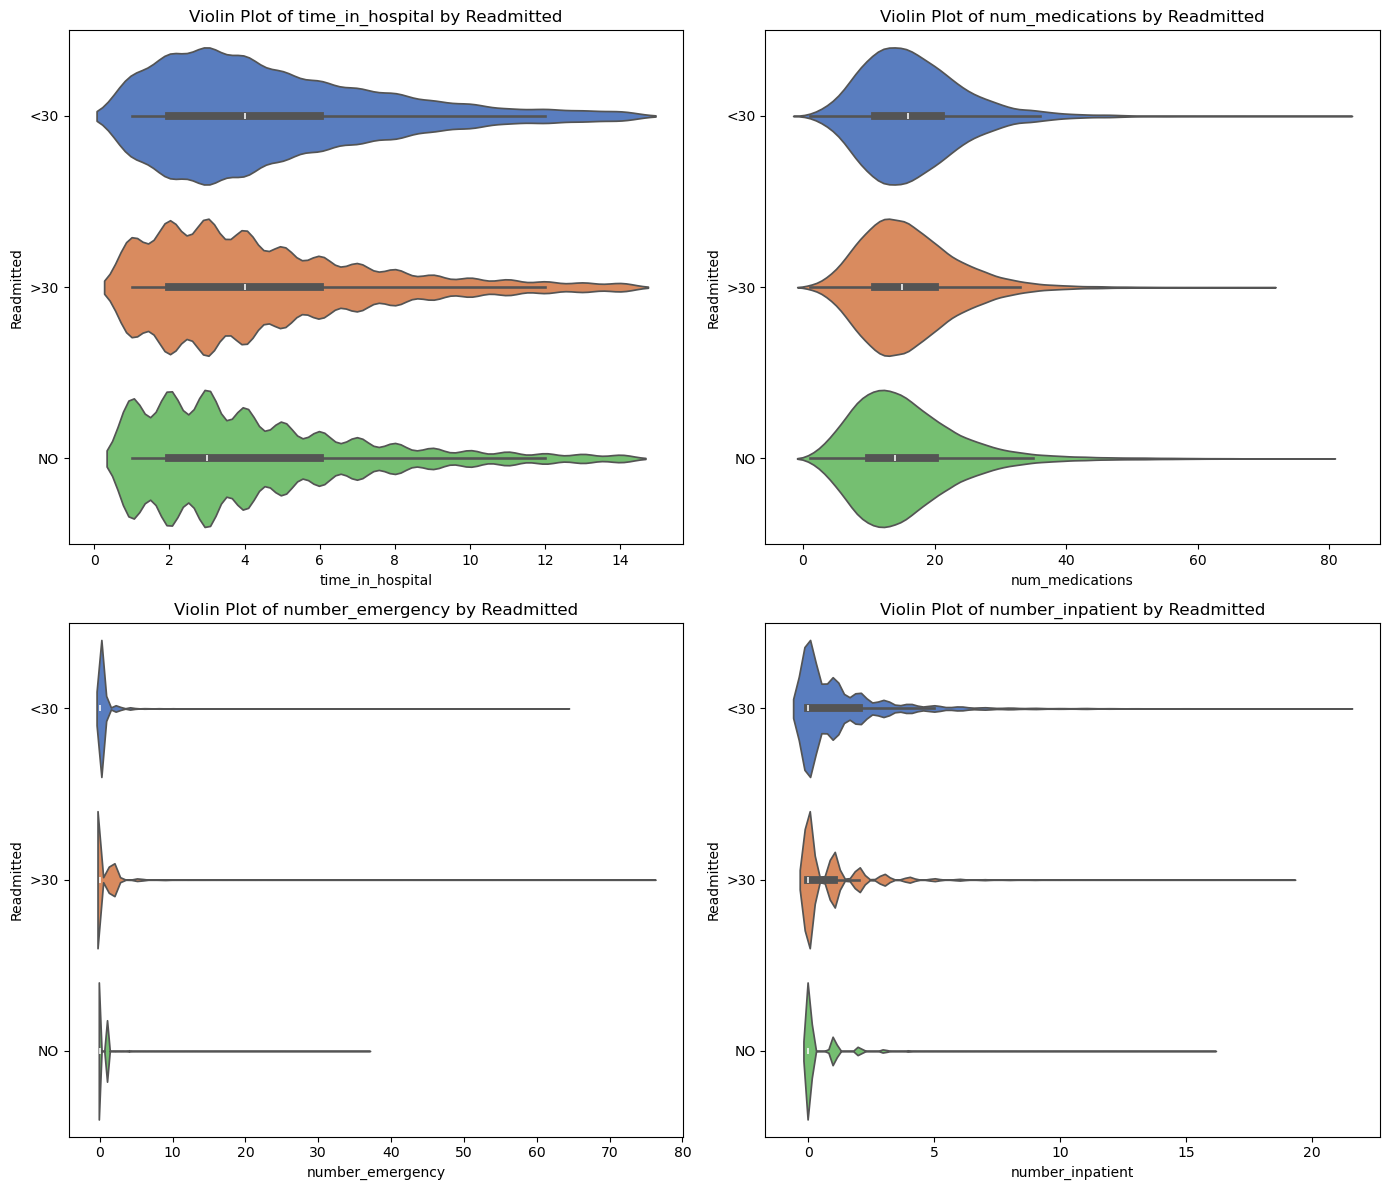

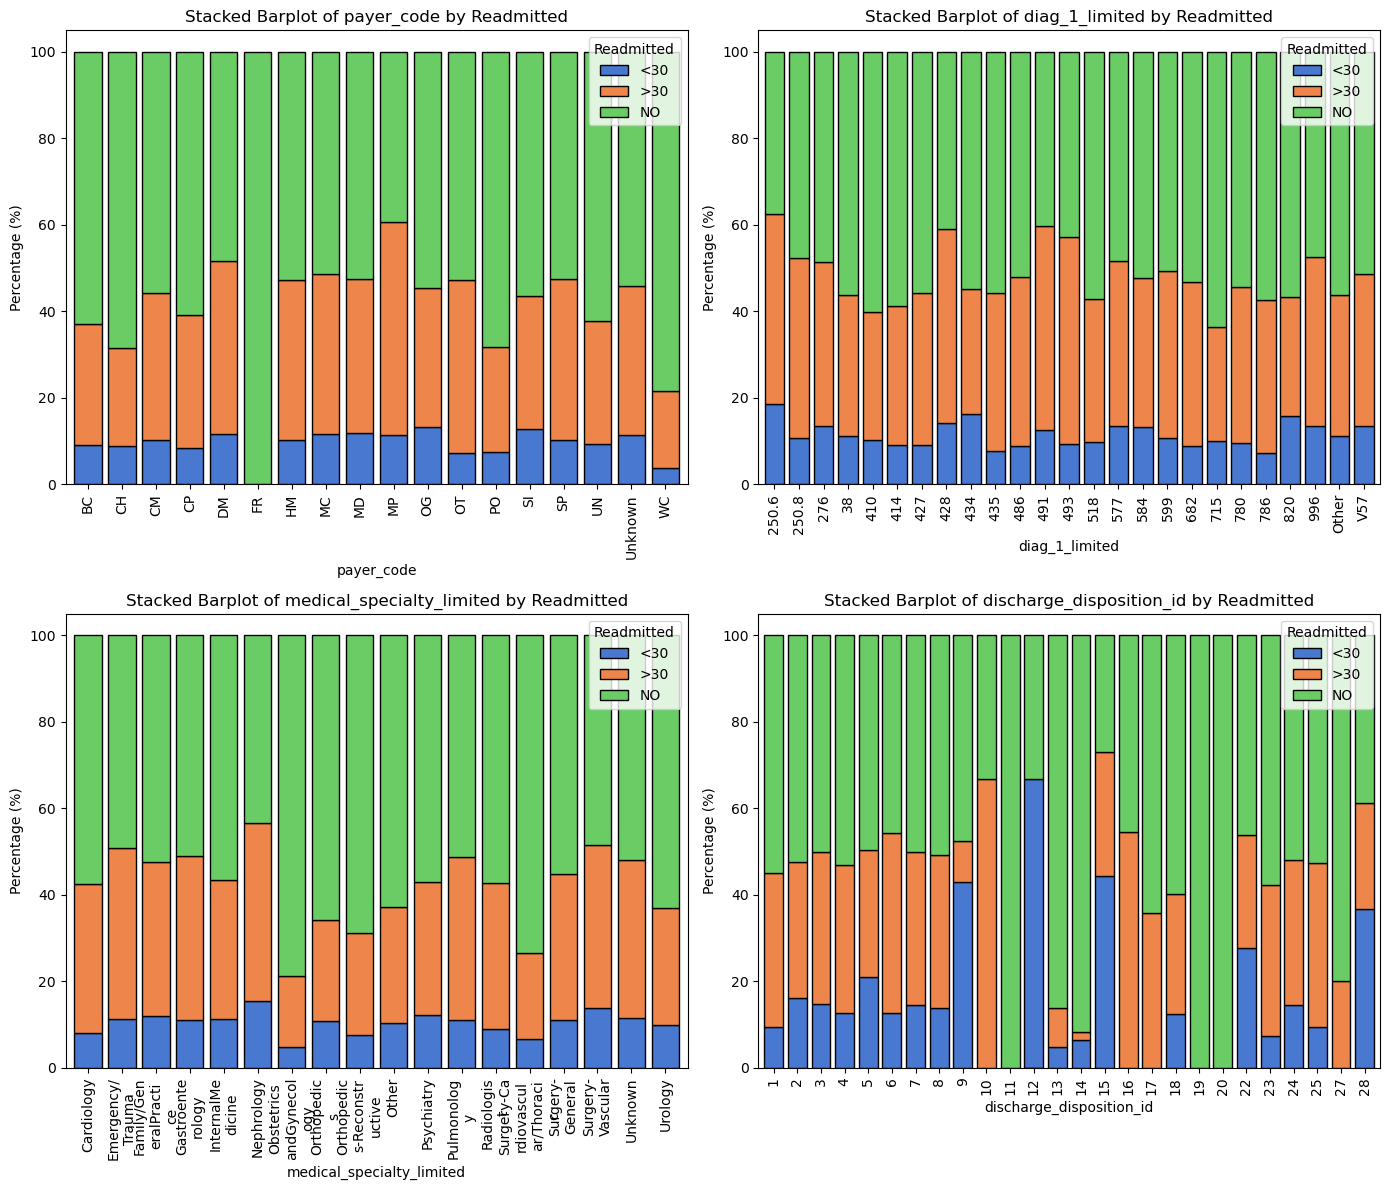

In [46]:
from textwrap import wrap

df_plotting = df_clean.copy()

# Filter diag_1 and medical specialty to include only categories with more than 1000 occurrences
diag_1_top_values = df_plotting['diag_1'].value_counts()
diag_1_top_values = diag_1_top_values[diag_1_top_values > 1000].index
df_plotting['diag_1_limited'] = df_plotting['diag_1'].where(df_plotting['diag_1'].isin(diag_1_top_values), other='Other')
med_spec_top_values = df_plotting['medical_specialty'].value_counts()
med_spec_top_values = med_spec_top_values[med_spec_top_values > 500].index
df_plotting['medical_specialty_limited'] = df_plotting['medical_specialty'].where(df_plotting['medical_specialty'].isin(med_spec_top_values), other='Other')

# Define numeric and categorical variables
numVar = ['time_in_hospital', 'num_medications', 'number_emergency', 'number_inpatient']
catVar = ['payer_code', 'diag_1_limited', 'medical_specialty_limited', 'discharge_disposition_id']

# Violin Plots for Numeric Variables in Two Columns
ncols = 2  # Number of columns in the grid
nrows = -(-len(numVar) // ncols)  # Calculate the number of rows needed (ceiling division)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))  # Adjust size for clarity
axes = axes.flatten()  # Flatten axes for easier indexing if nrows * ncols > len(numVar)

for i, var in enumerate(numVar):
    ax = axes[i]  # Get the appropriate subplot axis
    sns.violinplot(
        data=df_plotting, 
        x=var, 
        y='readmitted', 
        hue = 'readmitted',
        order=readmit_order,
        palette='muted', 
        ax=ax
    )
    ax.set_title(f'Violin Plot of {var} by Readmitted')
    ax.set_xlabel(var)
    ax.set_ylabel('Readmitted')

# Hide any unused subplots
for j in range(len(numVar), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f'plots/grouped_violinplots.png')
plt.show()

# Stacked Barplots for Categorical Variables in Two Columns
ncols = 2  # Number of columns in the grid
nrows = -(-len(catVar) // ncols)  # Calculate the number of rows needed (ceiling division)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
axes = axes.flatten()  # Flatten axes for easier indexing if nrows * ncols > len(catVar)

for i, var in enumerate(catVar):
    ax = axes[i]  # Get the appropriate subplot axis
    # Calculate proportions of response classes within each level of the categorical variable
    grouped_counts = (
        df_plotting.groupby(var, observed=True)['readmitted']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )
    # Plot stacked barplot
    grouped_counts[readmit_order].plot(
        kind='bar', 
        stacked=True, 
        ax=ax, 
        color=sns.color_palette("muted"), 
        edgecolor='black',
        width=0.8
    )
    ax.set_title(f'Stacked Barplot of {var} by Readmitted')
    ax.set_xlabel(var)
    ax.set_ylabel('Percentage (%)')
    ax.legend(title='Readmitted', loc='upper right')
    ax.tick_params(axis='x', rotation=0)  # Prevent rotation here for cleaner wrapping

    # Dynamically fetch and wrap the x-tick labels
    labels = [ '\n'.join(wrap(label, 10)) for label in grouped_counts.index.astype(str)]
    ax.set_xticks(range(len(labels)))  # Ensure tick positions match
    ax.set_xticklabels(labels, rotation=90)  # Apply wrapped labels

# Hide any unused subplots
for j in range(len(catVar), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f'plots/stacked_barplots.png')
plt.show()

Observations on the Plots

**Violin Plots:**

- **time_in_hospital**: The distribution for early readmitted patients is smoother with a slightly higher median compared to those not readmitted. All distributions are right-skewed.
- **num_medications**: There are subtle differences in the range and medians.
  - Late readmissions have a slightly narrower range that the other two classes.
  - The 'NO' class has the smallest median.
  - Late readmitted has the largest median.
- **number_emergency**: Differences appear in the tails of the distributions:
  - The 'NO' class has the smallest range.
  - Late readmitted has the largest range.
  - Early readmitted falls in between. 
  This could suggest that late readmitted patients may experience more unexpected health challenges, often treated in emergency settings. Most observations fall between 0 and a few visits, but early readmitted patients have more observations in the "few visits" range compared to zero visits.
- **number_inpatient**: The range increases across classes:
  - The 'NO' class has the smallest range.
  - Early readmitted has the largest range. 
  For the 'NO' class, most observations are at zero, whereas for early readmitted patients, the distribution becomes denser in the 0-5 range.

**Stacked Bar Plots:**

- **payer_code**: 
  - All observations from the 'FR' category are not readmitted, possibly indicating very few observations in this category.
  - 'MP' and 'DM' show the smallest proportions of not readmitted cases.
- **diag_1**: Among the 24 most frequent primary diagnosis codes plus an other category:
  - Codes with the lowest proportions of not readmitted patients include 250.6, 428, 491, and 493.
  - Code 715 has the highest proportion of not readmitted patients.
  - Codes 786 and 435 have the fewest early readmitted patients.
- **medical_specialty**: Among the 16 most frequent medical specialties plus other and unknown categories:
  - Nephrology is the specialty with the lowest proportion of not readmitted and highest proportion of early readmitted patients.
  - Specialties with the smallest proportion of early readmitted and largest proportion of not readmitted patients are Obstetrics/Gynecology and Surgery - Cardiovascular/Thoracic.
- **discharge_disposition_id**: 
  - Categories 11, 19, and 20 show no readmitted observations, likely due to having very few total observations.
  - Category 12 has the highest percentage of early readmitted patients and one of the lowest percentages of not readmitted patients, with no late readmitted observations.
  - Category 15 shows the lowest proportion of not readmitted and among the highest of early readmitted.

#### 3.4.6 Relationships between features

##### ***Explore relationships between attributes: Look at the attributes via scatterplots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.***

**A. Scatterplot matrix**

/var/folders/xc/xy2drgvd7_18v0mjfy9sz8mc0000gn/T/ipykernel_17828/950256561.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.1))


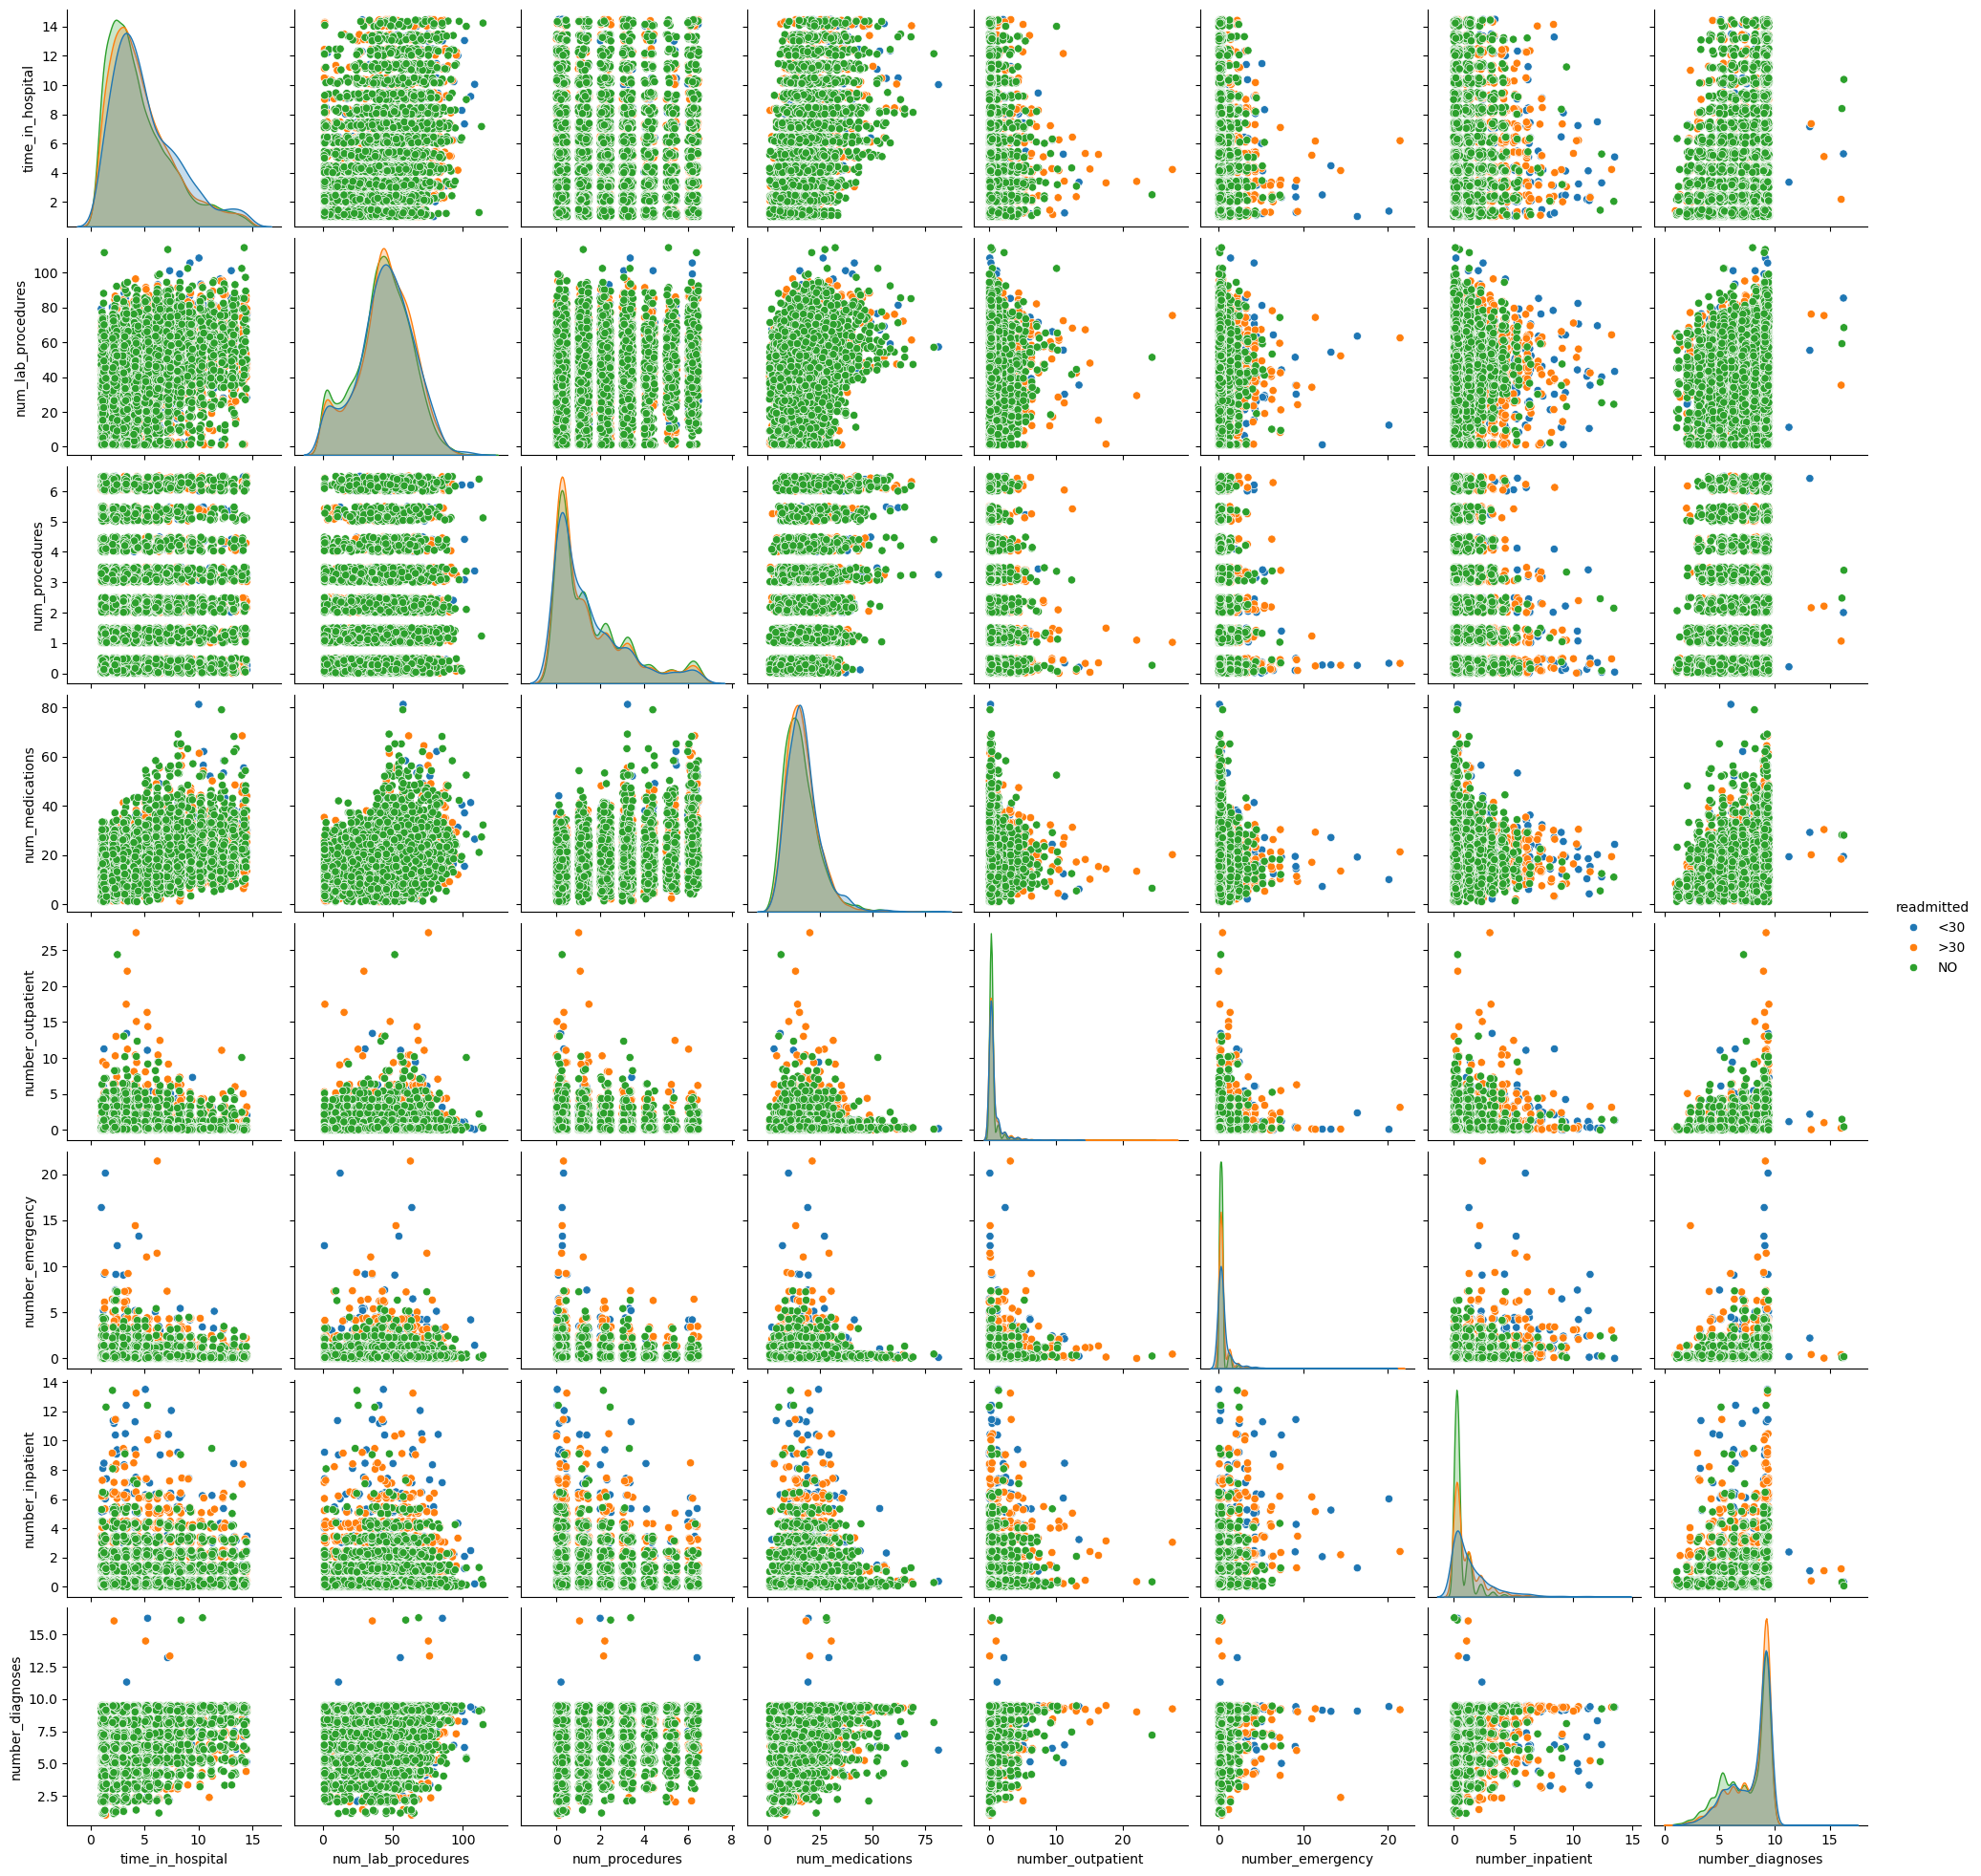

In [47]:
# Scatter plot matrix of the numeric variables

# This doesn't work.
# import warnings

# # Suppress DeprecationWarning and FutureWarning
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore', category=DeprecationWarning)
#     warnings.filterwarnings('ignore', category=FutureWarning)

# Sample 10% of the 100K record dataset
sample_size = int(0.1 * len(df_clean))

df_sampled = (
    df_clean.groupby('readmitted', group_keys=False, observed=False)
    .apply(lambda x: x.sample(frac=0.1))
    .reset_index(drop=True)
)

# Ensure the 'readmitted' column is present explicitly
df_sampled = df_sampled.loc[:, df_clean.columns]

# Add jitter to numeric variables
df_sampled_jittered = df_sampled.copy()
numeric_cols = df_sampled.select_dtypes(include=['int64']).columns

df_sampled_jittered[numeric_cols] = df_sampled_jittered[numeric_cols].values + \
    np.random.rand(len(df_sampled_jittered), len(numeric_cols)) / 2

# Create the pairplot
sns.pairplot(
    data=df_sampled_jittered,
    hue="readmitted",          # Group by 'readmitted'
    diag_kws={"common_norm": False}, # Default ensures densities are group-specific    
);
# plt.savefig(f'plots/matrixScatter.png')

**B. Correlation matrix**

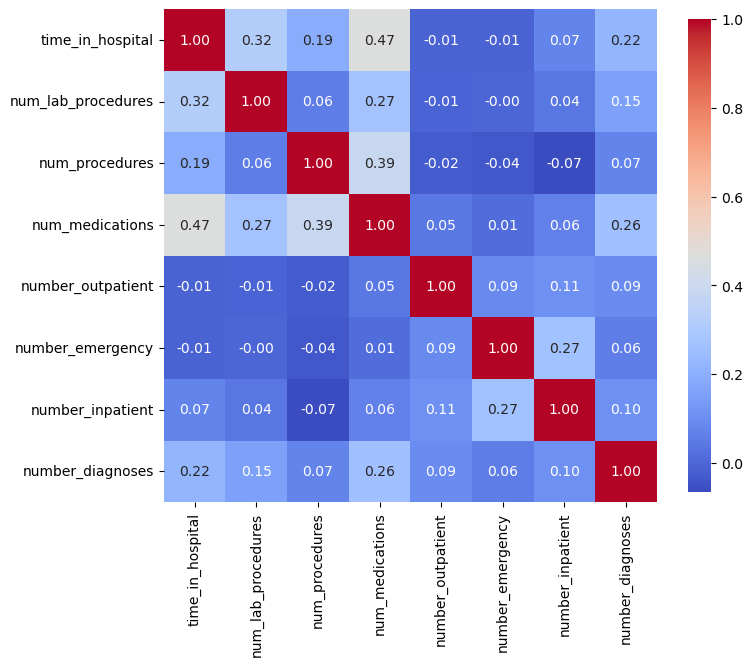

In [48]:
# Select only numeric columns for the correlation matrix
numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create the plot
f, ax = plt.subplots(figsize=(8, 8))  # Figure and axes
sns.heatmap(corr_matrix,
            annot=True,         # Plot numeric annotations
            fmt=".2f",          # Format for annotations
            square=True,        # Keep cells square
            cmap=sns.color_palette("coolwarm", as_cmap=True),
            cbar_kws={"shrink": 0.7},  # Colorbar customization
            ax=ax)              # Use the same axis

# Adjust layout
f.tight_layout()
# plt.savefig(f'plots/correlationplt.png')
plt.show()

From the correlation plot, the numerical variables don't show a lot of evidence of correlation or multicollinearity. `num_medications` is somewhat correlated with `time_in_hospital` (0.47) and `num_procedures` (0.39).

**C. Cross tabulations**

It would be interesting to get a sense of the medications by payer. Are some providers more likely to pay for certain medications?

discharge_id_limited      1    2     3     6    18  Other
payer_code                                               
BC                     3711  147   189   421     0    187
CH                      119    1     4    15     0      7
CM                     1129   41   351   282     1    133
CP                     1908   65   147   264     3    146
DM                      397    8    27    82     2     33
FR                        1    0     0     0     0      0
HM                     4158  256   533  1047     2    278
MC                    16024  688  7659  5052     9   3007
MD                     2362   42   510   318     0    300
MP                       59    3     4     9     0      4
OG                      840   33    22    55     0     83
OT                       83    2     2     3     0      5
PO                      445    5    31    73     0     38
SI                       42    2     3     6     0      2
SP                     3548  117   545   459     0    338
UN            

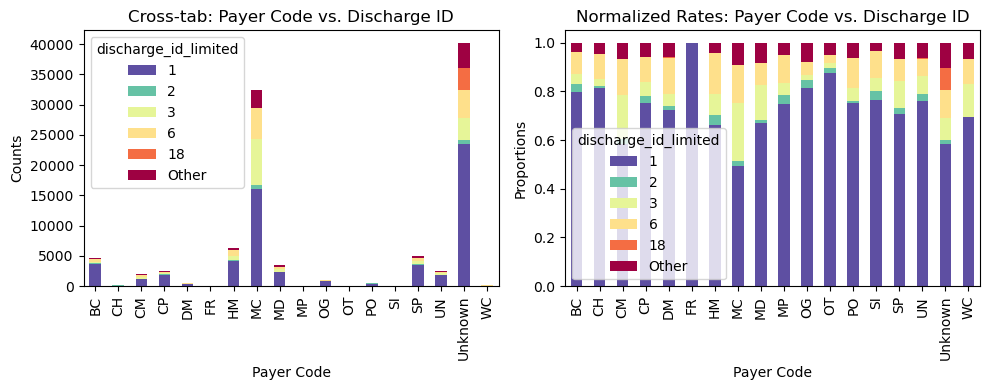

In [49]:
# Filter to include only categories with more than 2000 occurrences
discharge_top_values = df_plotting['discharge_disposition_id'].value_counts()
discharge_top_values = discharge_top_values[discharge_top_values > 2000].index

# Ensure 'Other' is included in the categories
if 'Other' not in df_plotting['discharge_disposition_id'].cat.categories:
    df_plotting['discharge_disposition_id'] = df_plotting['discharge_disposition_id'].cat.add_categories(['Other'])

# Apply the where condition to limit categories
df_plotting['discharge_id_limited'] = df_plotting['discharge_disposition_id'].where(
    df_plotting['discharge_disposition_id'].isin(discharge_top_values), 
    other='Other'
)

# Create cross-tab
discharge_crosstab = pd.crosstab(df_plotting['payer_code'], df_plotting['discharge_id_limited'])
print(discharge_crosstab)

# Normalize the cross-tab to calculate rates
discharge_rate = discharge_crosstab.div(discharge_crosstab.sum(1).astype(float), axis=0)

# Plot the cross-tab and normalized rates
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot cross-tab
discharge_crosstab.plot(kind='bar', stacked=True, colormap='Spectral_r', ax=axes[0])
axes[0].set_title('Cross-tab: Payer Code vs. Discharge ID')
axes[0].set_ylabel('Counts')
axes[0].set_xlabel('Payer Code')

# Plot normalized rates
discharge_rate.plot(kind='bar', stacked=True, colormap='Spectral_r', ax=axes[1])
axes[1].set_title('Normalized Rates: Payer Code vs. Discharge ID')
axes[1].set_ylabel('Proportions')
axes[1].set_xlabel('Payer Code')

plt.tight_layout()
# plt.savefig(f'plots/crosstab_payer_discharge.png')
plt.show()

This displays the most frequent discharge codes for each payer. The discharge code descriptions follow:
- 1: Discharged to home
- 2: Discharged/transferred to another short-term hospital
- 3: Discharged/transferred to SNF
- 6: Discharged/transferred to home with home health service
- 18: NULL (Does this mean they died?)

'MC' patients have the smallest proportion discharged to home and with `CM` the largest discharged to SNF, which may be a supervised nursing facility. There is quite a bit of variability between these two variables.  

Additionally, are some payers more likely to have patients that get emergency treatment?

number_emergency_binned      0   1-3  4-5  6-10  11+
payer_code                                          
BC                        4035   522   47    39   12
CH                         128    18    0     0    0
CM                        1650   245   31     5    6
CP                        2337   182   11     2    1
DM                         366   128   20    19   16
FR                           1     0    0     0    0
HM                        5093   957  165    57    2
MC                       28133  3762  390   130   24
MD                        2788   523  112    72   37
MP                          58    19    2     0    0
OG                         790   142   61    31    9
OT                          78    14    2     1    0
PO                         541    48    3     0    0
SI                          48     7    0     0    0
SP                        4444   493   44    21    5
UN                        2175   225   29    15    4
Unknown                  37590  2427  182    5

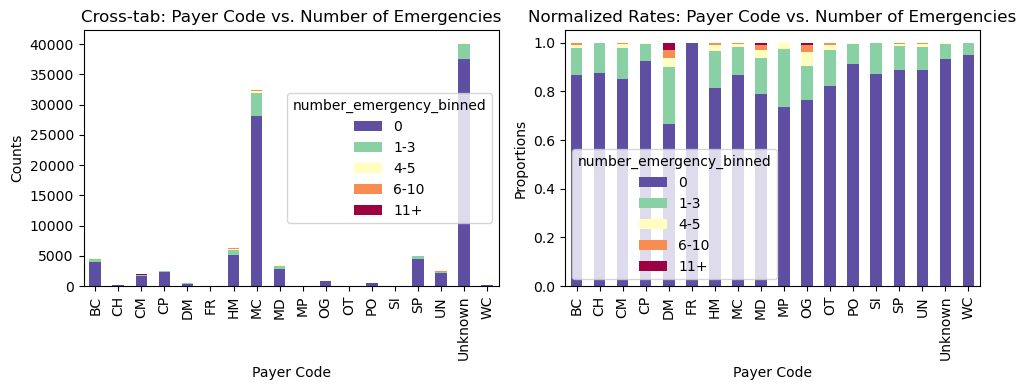

In [50]:
# Define bin edges and labels
bins = [0, 1, 3, 5, 10, float('inf')]  # Define bin edges
labels = ['0', '1-3', '4-5', '6-10', '11+']  # Define category labels

# Bin the 'number_emergency' variable
df_clean['number_emergency_binned'] = pd.cut(df_clean['number_emergency'], bins=bins, labels=labels, right=False)

# Create cross-tab
emergency_crosstab = pd.crosstab(df_clean['payer_code'], df_clean['number_emergency_binned'])
print(emergency_crosstab)

# Normalize the cross-tab to calculate rates
emergency_rate = emergency_crosstab.div(emergency_crosstab.sum(1).astype(float), axis=0)

# Plot the cross-tab and normalized rates
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot cross-tab
emergency_crosstab.plot(kind='bar', stacked=True, colormap='Spectral_r', ax=axes[0])
axes[0].set_title('Cross-tab: Payer Code vs. Number of Emergencies')
axes[0].set_ylabel('Counts')
axes[0].set_xlabel('Payer Code')

# Plot normalized rates
emergency_rate.plot(kind='bar', stacked=True, colormap='Spectral_r', ax=axes[1])
axes[1].set_title('Normalized Rates: Payer Code vs. Number of Emergencies')
axes[1].set_ylabel('Proportions')
axes[1].set_xlabel('Payer Code')

plt.tight_layout()
# plt.savefig(f'plots/crosstab_payer_emergencies.png')
plt.show()

From earlier, we saw that the `DM` payer had one of the smallest proportions of the not readmitted class. Interestingly from the cross tab here, DM also appears to be associated with the most number of emergency visits and the smallest proportion of patients with zero emergency visits.  

##### ***Are there other features that could be added to the data or created from existing features? Which ones?***

Some options for combining features for simplicity are to group drugs by classes and group diagnosis codes by health category (e.g. cardiovascular, endocrine, etc.). Variables with many categorical levels could be reorganized to group sparce levels into an other category (e.g. payer_code, medical_specialty, and discharge_disposition_id). Another option to consider would be restricting the analysis to adults over 20 years old. The dataset primarily consists of adults and it seems logical that the disease, treatments and outcomes of children might be different than adults.

#### 3.4.5 One hot encoding and dimensionality reduction

##### ***Additional analyses (e.g. implement dimensionality reduction, then visualize and interpret the results).***

##### **A. One hot encoding**

In [51]:
# Remove columns with many missing values and patient IDs
columns_to_drop = ['patient_nbr'] #, 'weight', 'max_glu_serum', 'A1Cresult']
df_encoded = df_clean.drop(columns= columns_to_drop)

# Preprocess diag_1, diag_2, diag_3 combining all 
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_encoded[col] = df_encoded[col].str.split('.').str[0]  # Drop decimals and digits after
# print(df_encoded[['diag_1', 'diag_2', 'diag_3']].head(20))

# # Replace NaNs in 'medical_specialty' and 'payer_code' with 'unknown'
# categorical_na_columns = ['medical_specialty', 'payer_code']
# for col in categorical_na_columns:
#     df_encoded[col] = df_encoded[col].fillna('unknown')

# Drop rows with NaN values (race and diagnoses cols)
df_encoded = df_encoded.dropna()

# Remove target (split into X and y, for plotting with y later)
X_df_encoded = df_encoded.drop(columns='readmitted')
y_df_encoded = df_encoded['readmitted']

# Handle categorical variables with one-hot encoding
categorical_columns = X_df_encoded.select_dtypes(include=['object', 'category']).columns
X_df_encoded = pd.get_dummies(X_df_encoded, columns=categorical_columns, drop_first=False)

# Standardize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df_encoded)

**B. PCA**

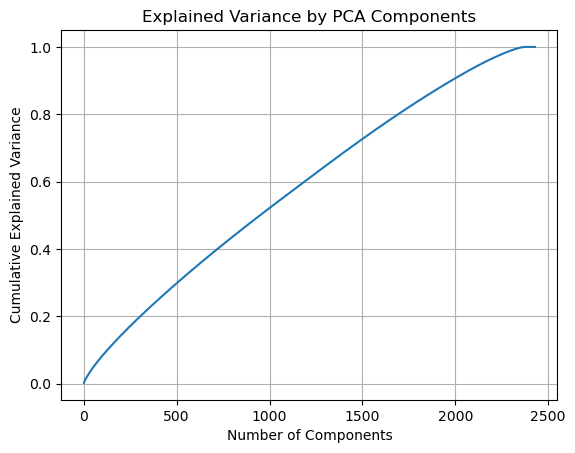

In [52]:
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA()  # Keep all components initially
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
# plt.savefig(f'plots/PCAexplainedVariance.png')
plt.show()

In [53]:
# Determine the number of components to explain ~80% of variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1  # +1 because indices start at 0
print(f"Number of original features: {X_df_encoded.shape[1]}\nNumber of components to explain ~80% of variance: {n_components_80}")

Number of original features: 2428
Number of components to explain ~80% of variance: 1692


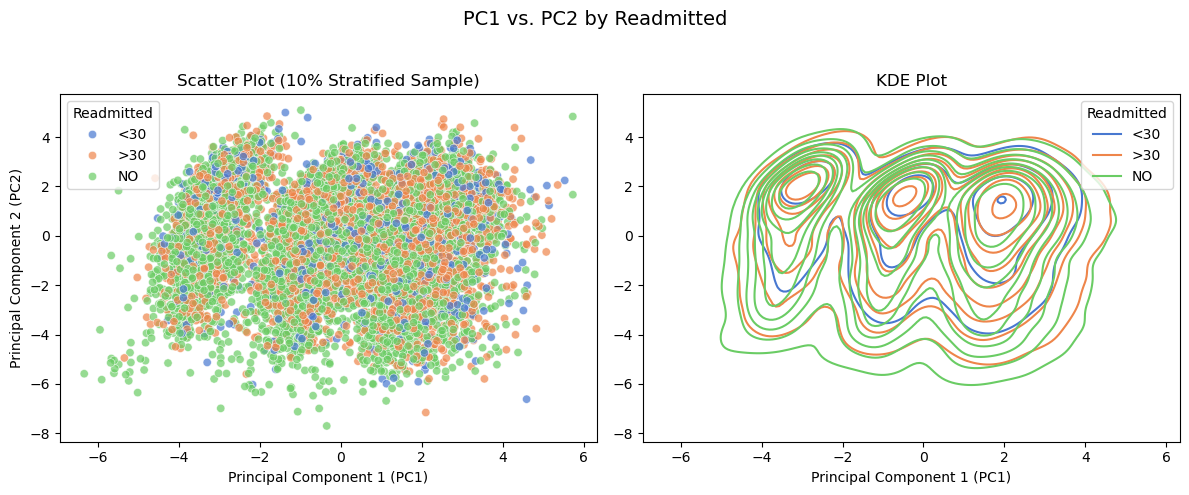

In [54]:
from sklearn.model_selection import train_test_split

# Plot PC1 vs PC2 by response class

pc1 = X_pca[:, 0]  # First principal component
pc2 = X_pca[:, 1]  # Second principal component

pca_df = pd.DataFrame({
    'PC1': pc1,
    'PC2': pc2,
    'Readmitted': y_df_encoded
})

# Perform stratified sampling (10%)
pca_sample, _ = train_test_split(
    pca_df,
    test_size=0.9,  # Keep 10% of the data
    stratify=pca_df['Readmitted'],  # Stratify by the 'Readmitted' column
    random_state=1234
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot with the stratified sample
sns.scatterplot(
    data=pca_sample,
    x='PC1',
    y='PC2',
    hue='Readmitted',
    palette='muted',
    alpha=0.7,
    ax=ax1
)
ax1.set_title('Scatter Plot (10% Stratified Sample)')
ax1.set_xlabel('Principal Component 1 (PC1)')
ax1.set_ylabel('Principal Component 2 (PC2)')
ax1.legend(title='Readmitted')

# Get axis limits from scatterplot
x_limits = ax1.get_xlim()
y_limits = ax1.get_ylim()

# KDE plot with full data, matching axis limits
sns.kdeplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Readmitted',
    palette='muted',
    ax=ax2,
    legend=True
)
ax2.set_title('KDE Plot')
ax2.set_xlabel('Principal Component 1 (PC1)')
ax2.set_ylabel('')

# Apply matching axis limits
ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)

# Add a figure-wide title
fig.suptitle('PC1 vs. PC2 by Readmitted', fontsize=14)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to prevent overlap with suptitle
# plt.savefig('plots/PC1vPC2_by_readmitted.png')
plt.show()

These plots display only the first two principal components (PCs) out of the 1690 required to explain 80% of the variance. While these two PCs do not separate the response classes, they reveal distinct patterns in the data distribution:
- Non-readmitted patients spread widely extending to the exterior boundaries of the plot.  
- Early readmitted patients cluster more densely near the center, suggesting a smaller variance in their principal component scores.  
- Late readmitted patients have a broader distribution than early readmitted patients but less spread than the non-readmitted group.  

Although the PCs are less interpretable, PCA successfully reduced the dataset from the original 2453 one-hot-encoded features. This dimensionality reduction may be useful for further analyses and modeling.
